In [97]:
import pickle
import os
import numpy as np
import datetime
from tqdm.notebook import tqdm

def find_label(station_list):
    DIR = os.getcwd()
    data_path = os.path.join(DIR, 'data/arc/output')
    arc_list = sorted(os.listdir(data_path))
    
    label = dict()
    
    for station_name in station_list:
        ecpt_cnt = 0
        
        if station_name not in label.keys():
            label[station_name] = dict()
            label[station_name]['p_arv'] = list()
            label[station_name]['s_arv'] = list()
            
        for arc in tqdm(arc_list):
            f = open(os.path.join(data_path, arc), 'r')
            lines = f.readlines()[2:-2]
        #     print(lines)

            for line in lines:

                if line[2:4] == station_name[2:4]:
                    try:
                        p_arv = ('20' + line[9:19] + line[20:24]).replace(' ', '0')
                        s_arv = ('20' + line[9:19] + line[32:36]).replace(' ', '0')

                        if s_arv[12] == '6':
                            s_arv = s_arv[:12] + '0' + s_arv[12:]
                            p_arv = datetime.datetime.strptime(p_arv, "%Y%m%d%H%M%S%f")
                            s_arv = datetime.datetime.strptime(s_arv, "%Y%m%d%H%M%S%f") + datetime.timedelta(minutes=1)
                        else:
                            p_arv = datetime.datetime.strptime(p_arv, "%Y%m%d%H%M%S%f")
                            s_arv = datetime.datetime.strptime(s_arv, "%Y%m%d%H%M%S%f")
                    except:
                        ecpt_cnt += 1
#                         print(p_arv)
#                         print(s_arv[12])
                        pass
                    label[station_name]['p_arv'].append(p_arv)
                    label[station_name]['s_arv'].append(s_arv)
        print('P-Arrival label \t: ', len(label[station_name]['p_arv']))
        print('S-Arrival label \t: ', len(label[station_name]['s_arv']))
        print('exception occurs \t: ', ecpt_cnt)
    
    return label



def labeling(station_name, label_data, ys):
    ecpt_y = list()
    p_label_cnt = 0
    s_label_cnt = 0

    for didx, data in tqdm(enumerate(label_data)):
        data['p_arv'] = list()
        data['s_arv'] = list()
        
        for idx, y_p in enumerate(ys[station_name]['p_arv']):
            try:
                if data['trace_start_time'] < y_p and data['trace_end_time'] > y_p:
                    data['p_arv'].append(y_p)
                    data['p_label'] = 1
                    p_label_cnt += 1
    
                if data['trace_end_time'] < y_p: # and data['start_time'] > y:
                    break

            except:
                ecpt_y.append(y_p)
                break
        
        for idx, y_s in enumerate(ys[station_name]['s_arv']):
            try:
                if data['trace_start_time'] < y_s and data['trace_end_time'] > y_s:
                    data['s_arv'].append(y_s)
                    data['s_label'] = 1
                    s_label_cnt += 1

                if data['trace_end_time'] < y_s: # and data['start_time'] > y:
                    break

            except:
                ecpt_y.append(y_s)
                break
                
    print('station name \t\t: ', station_name)
    print('P-label occurs \t\t: ', p_label_cnt)
    print('S-label occurs \t\t: ', s_label_cnt)
    print('exception occurs \t: ', len(np.unique(ecpt_y)))
                
    return label_data



def labeling_data(station_list, ys, data_amount = 10):
    DIR = os.getcwd()
    data_path = os.path.join(DIR, 'data/preprocessed_data')
    
    for station_name in station_list:
        
        file_list = os.listdir(os.path.join(data_path, station_name))
        try:
            file_list.remove('.ipynb_checkpoints')
        except:
            pass
        
        for idx, file in enumerate(file_list):
                
            with open(os.path.join(data_path, station_name, file), 'rb') as f:
                if idx == 0 and station_name == station_list[0]:
                    dataset = labeling(station_name, pickle.load(f), ys)
                else:
                    dataset = np.concatenate((dataset, labeling(station_name, pickle.load(f), ys)))
    
    return dataset

def labeling_time(dataset):
    except_cnt = 0
    
    for data in dataset:
        for wave in ['p', 's']:
            
            if data[wave+'_label'] == 0:
                data[wave+'_time_label'] = np.zeros(6000)

            else:
                tmp = np.zeros(6000)
                for arv in data[wave+'_arv']:
                    idx = int((arv - data['trace_start_time'])*6000 / (data['trace_end_time'] - data['trace_start_time']))
                    tmp[idx] = 1

                    for _ in range(1, 20):
                        try:
                            tmp[idx-_] = 1-(_*0.05)
                            tmp[idx+_] = 1-(_*0.05)
                        except:
                            except_cnt += 1
                            pass

                    
                data[wave+'_time_label'] = tmp
                
    print('total label occurs (p, s) : ', len(dataset)*2)
    print('execpt occurs : ', except_cnt)
    
    return dataset

In [61]:
DIR = os.getcwd()
data_path = os.path.join(DIR, 'data/mseed_data')
station_list = sorted(os.listdir(data_path))[:13]

In [71]:
ys = find_label(station_list)


P-Arrival label 	:  2707
S-Arrival label 	:  2707
exception occurs 	:  0



P-Arrival label 	:  1109
S-Arrival label 	:  1109
exception occurs 	:  0



P-Arrival label 	:  2750
S-Arrival label 	:  2750
exception occurs 	:  0



P-Arrival label 	:  2652
S-Arrival label 	:  2652
exception occurs 	:  0



P-Arrival label 	:  2159
S-Arrival label 	:  2159
exception occurs 	:  0



P-Arrival label 	:  2046
S-Arrival label 	:  2046
exception occurs 	:  0



P-Arrival label 	:  1226
S-Arrival label 	:  1226
exception occurs 	:  0



P-Arrival label 	:  2097
S-Arrival label 	:  2097
exception occurs 	:  0



P-Arrival label 	:  1757
S-Arrival label 	:  1757
exception occurs 	:  0



P-Arrival label 	:  1277
S-Arrival label 	:  1277
exception occurs 	:  0



P-Arrival label 	:  1368
S-Arrival label 	:  1368
exception occurs 	:  1



P-Arrival label 	:  1732
S-Arrival label 	:  1732
exception occurs 	:  1



P-Arrival label 	:  1659
S-Arrival label 	:  1659
exception occurs 	:  0


In [99]:
data = labeling_data(station_list, ys, data_amount=1)


station name 		:  PH01
P-label occurs 		:  580
S-label occurs 		:  580
exception occurs 	:  0



station name 		:  PH01
P-label occurs 		:  421
S-label occurs 		:  417
exception occurs 	:  0



station name 		:  PH02
P-label occurs 		:  414
S-label occurs 		:  417
exception occurs 	:  0



station name 		:  PH03
P-label occurs 		:  370
S-label occurs 		:  373
exception occurs 	:  0



station name 		:  PH03
P-label occurs 		:  633
S-label occurs 		:  623
exception occurs 	:  0



station name 		:  PH04
P-label occurs 		:  325
S-label occurs 		:  323
exception occurs 	:  0



station name 		:  PH04
P-label occurs 		:  666
S-label occurs 		:  667
exception occurs 	:  0



station name 		:  PH05
P-label occurs 		:  542
S-label occurs 		:  546
exception occurs 	:  0



station name 		:  PH05
P-label occurs 		:  439
S-label occurs 		:  441
exception occurs 	:  0



station name 		:  PH06
P-label occurs 		:  292
S-label occurs 		:  296
exception occurs 	:  0



station name 		:  PH06
P-label occurs 		:  641
S-label occurs 		:  641
exception occurs 	:  0



station name 		:  PH07
P-label occurs 		:  372
S-label occurs 		:  375
exception occurs 	:  0



station name 		:  PH07
P-label occurs 		:  557
S-label occurs 		:  558
exception occurs 	:  0



station name 		:  PH08
P-label occurs 		:  699
S-label occurs 		:  707
exception occurs 	:  0



station name 		:  PH08
P-label occurs 		:  267
S-label occurs 		:  263
exception occurs 	:  0



station name 		:  PH09
P-label occurs 		:  248
S-label occurs 		:  249
exception occurs 	:  0



station name 		:  PH09
P-label occurs 		:  629
S-label occurs 		:  633
exception occurs 	:  0



station name 		:  PH10
P-label occurs 		:  191
S-label occurs 		:  191
exception occurs 	:  0


In [102]:
data = labeling_time(data)

total label occurs (p, s) :  35790
execpt occurs :  594


In [103]:
print('data length \t: ', len(data))
print('data example \t: ', data[:1])

data length 	:  17895
data example 	:  [{'trace_start_time': datetime.datetime(2017, 11, 15, 10, 43, 52, 931000), 'trace_end_time': datetime.datetime(2017, 11, 15, 10, 44, 52, 931000), 'data': array([[   0.        ,   -0.        ,    0.        ],
       [   8.70582995,   -2.76577992,    1.69020492],
       [  35.59542344,  -11.44581954,    6.75770989],
       ...,
       [ 797.01182413, -294.64871976, -269.91942132],
       [ 370.5393191 , -292.07273144, -367.36249484],
       [ 219.34005356,  167.2770514 ,  -87.01053281]]), 'p_arv': [], 's_arv': [], 'p_label': 0, 's_label': 0, 'p_time_label': array([0., 0., 0., ..., 0., 0., 0.]), 's_time_label': array([0., 0., 0., ..., 0., 0., 0.])}]


In [104]:
t_data = [idx for idx, _ in enumerate(data) if _['p_label'] == 1]
f_data = [idx for idx, _ in enumerate(data) if _['p_label'] == 0]

print('Total data \t\t: ', len(data))
print('True label data \t: ', len(t_data))
print('False label data \t: ', len(f_data))
print('T/F Ratio \t\t: ', round(100*len(t_data)/len(f_data), 1))

Total data 		:  17895
True label data 	:  6442
False label data 	:  11453
T/F Ratio 		:  56.2


In [105]:
t_idx = np.random.choice(t_data, 15)
f_idx = np.random.choice(f_data, 15)

print(len(t_idx))
print(len(f_idx))
print(len(data[np.concatenate((t_idx, f_idx))]))

15
15


In [107]:
with open(os.path.join(DIR, 'labeled_dump_PUSAN/dump_03.pkl'), 'wb') as f:
    pickle.dump(data[np.concatenate((t_idx, f_idx))], f)

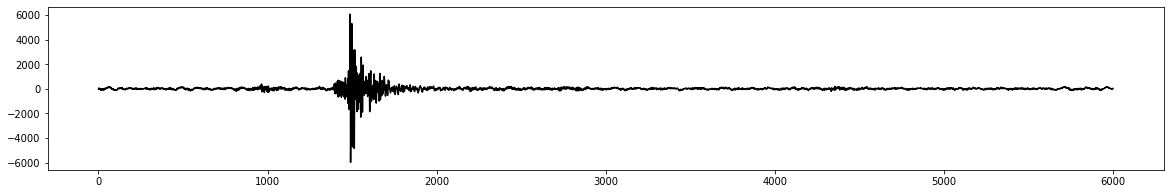

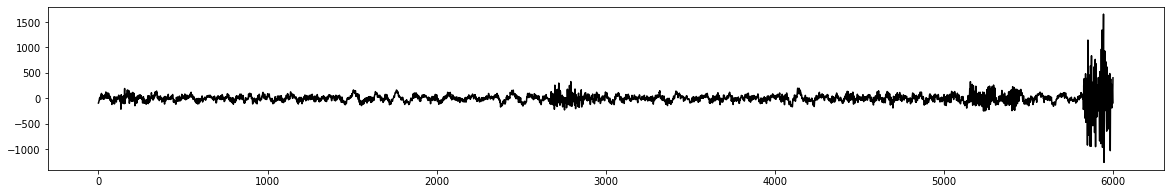

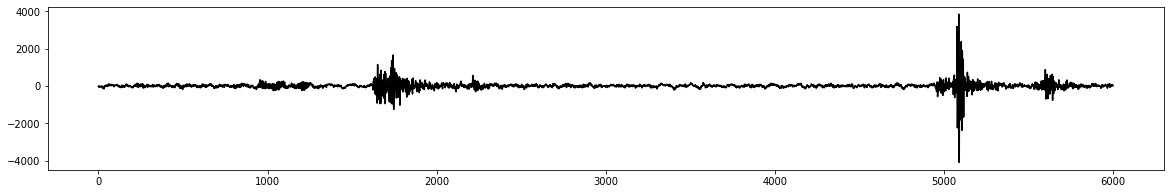

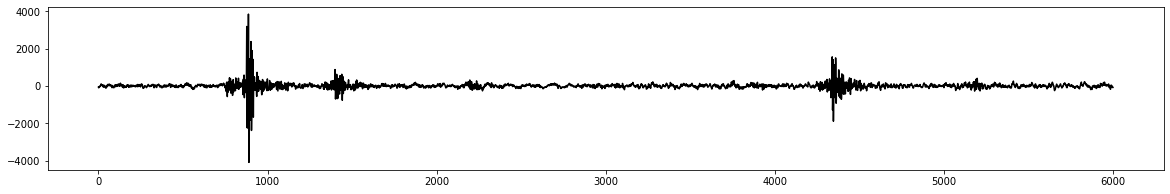

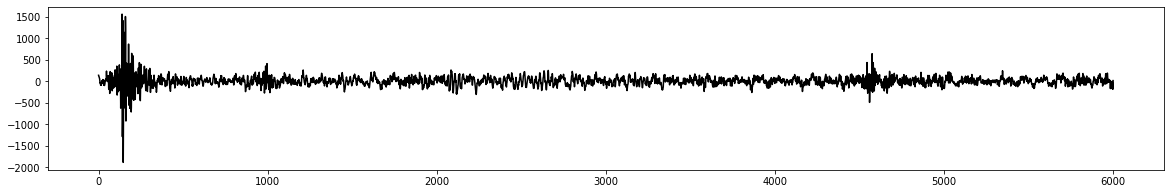

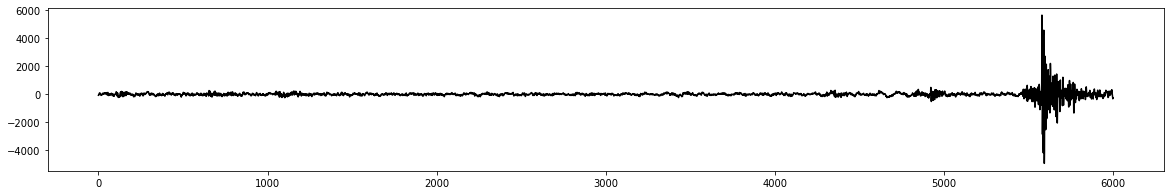

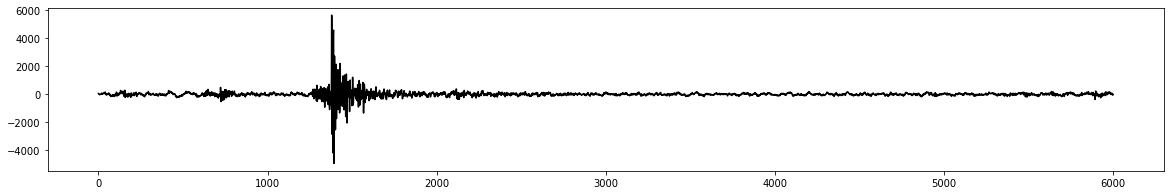

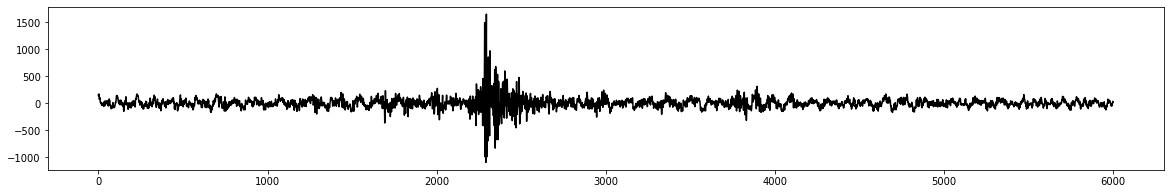

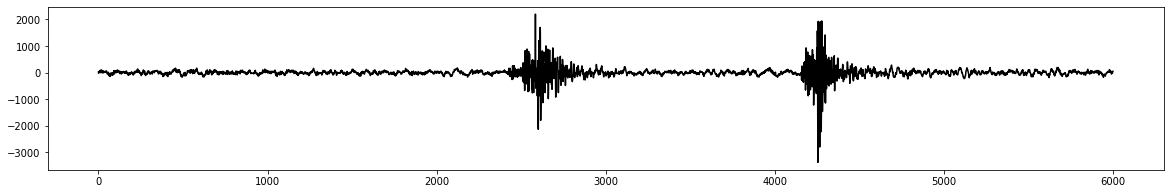

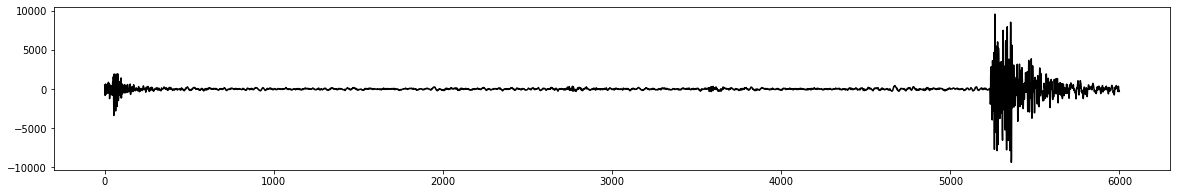

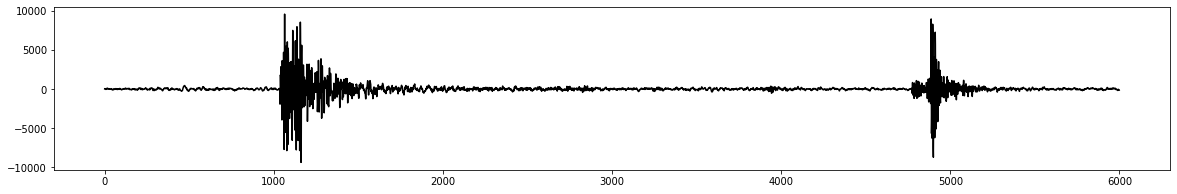

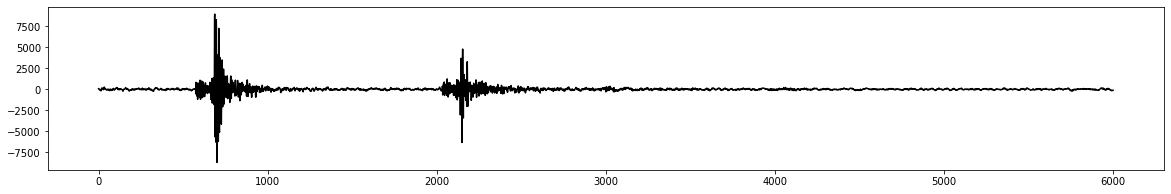

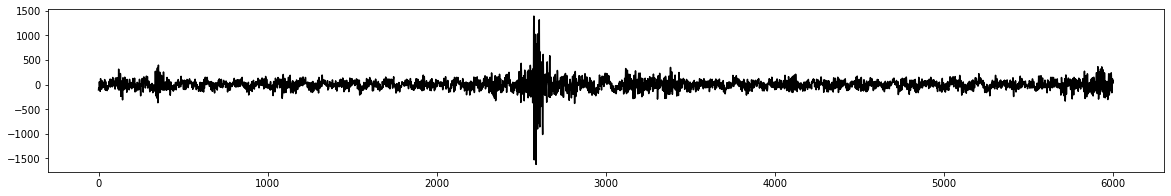

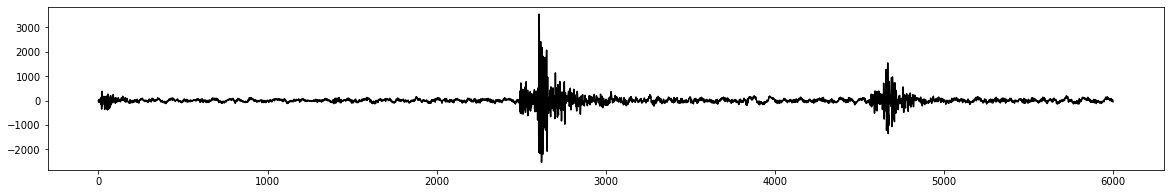

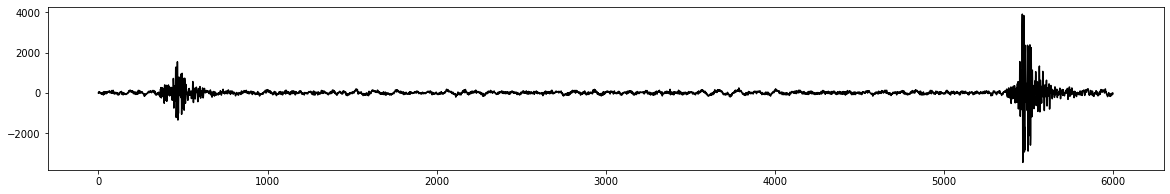

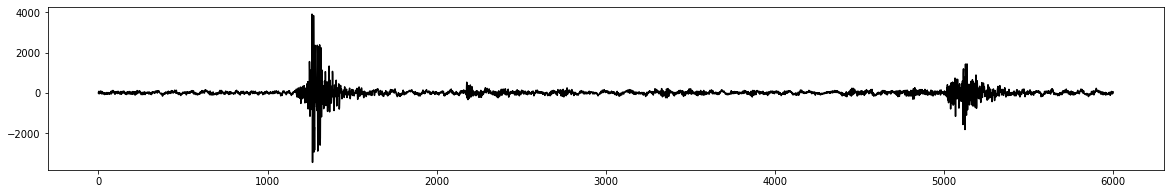

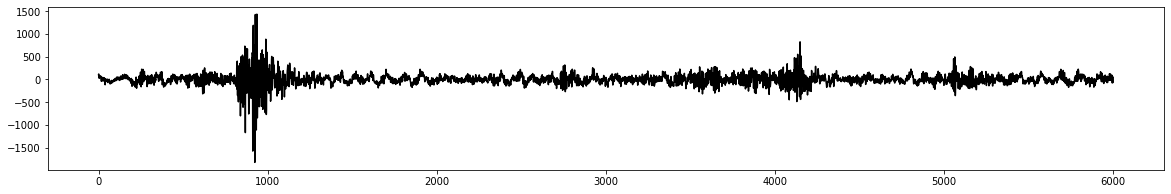

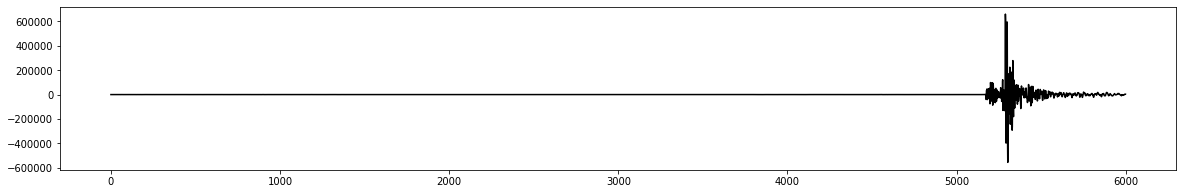

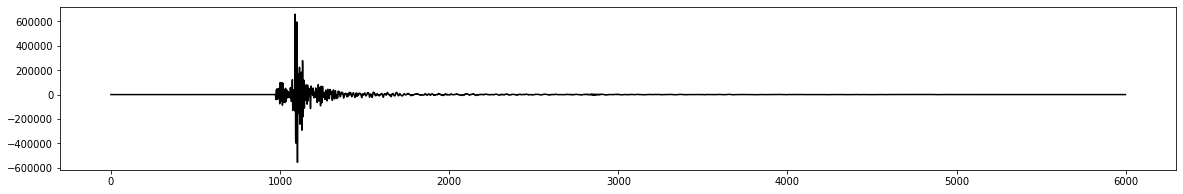

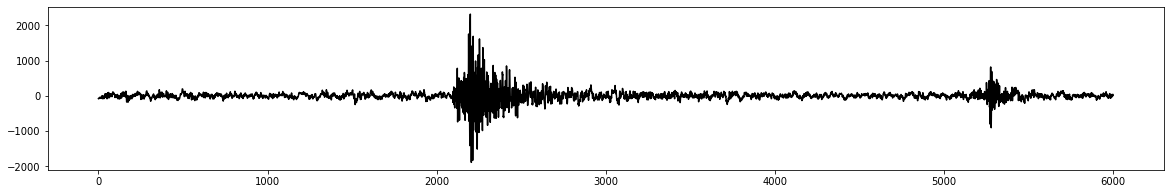

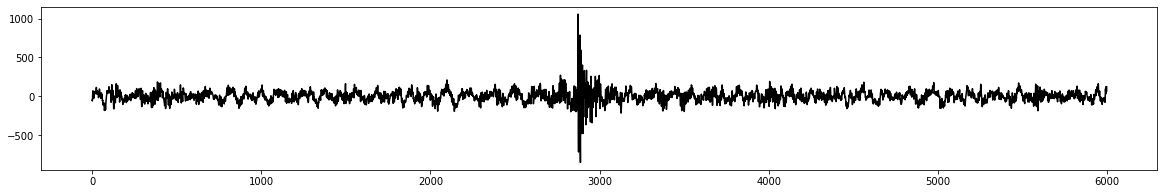

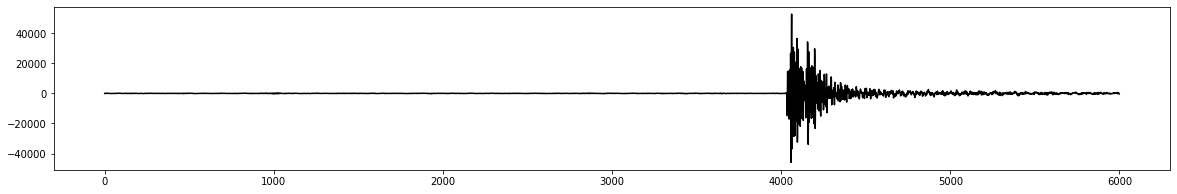

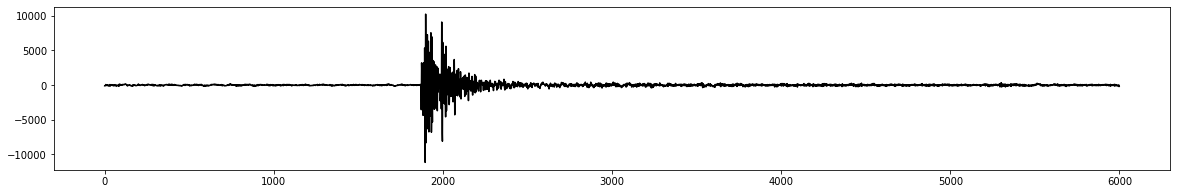

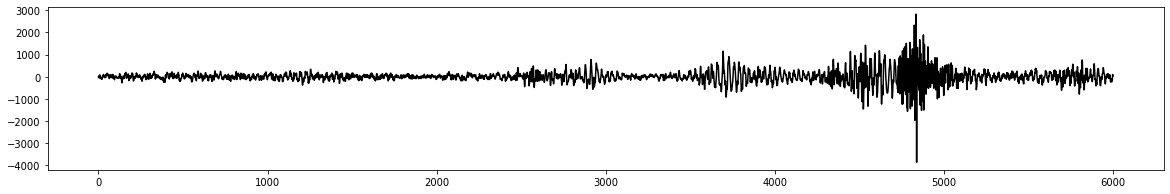

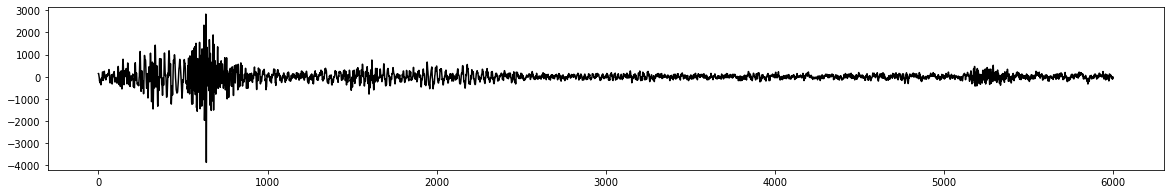

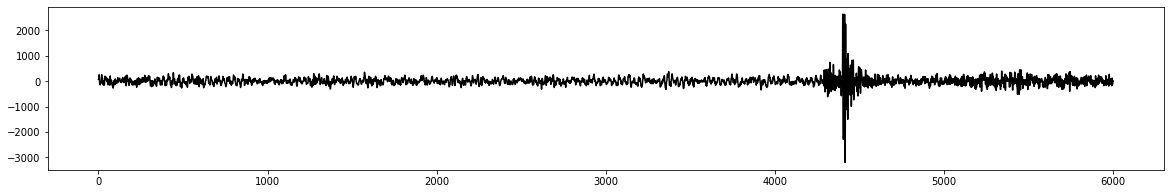

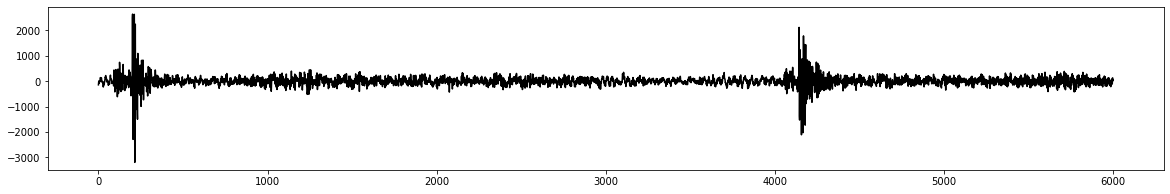

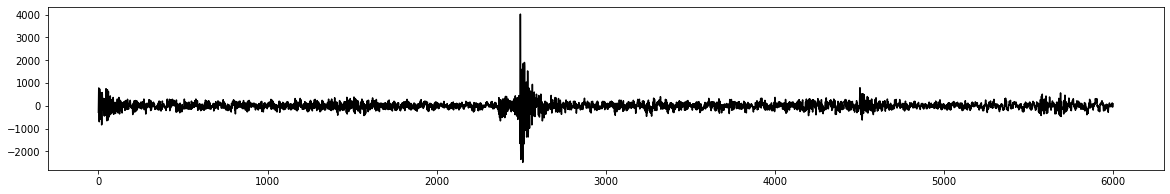

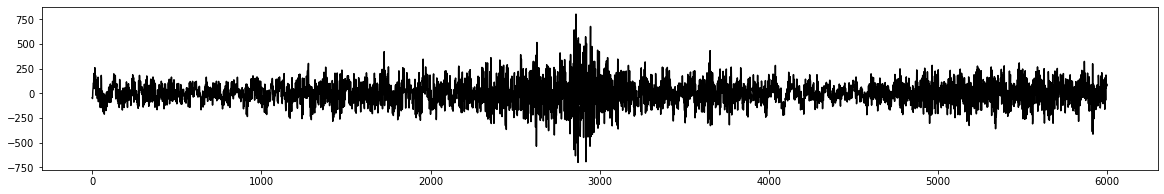

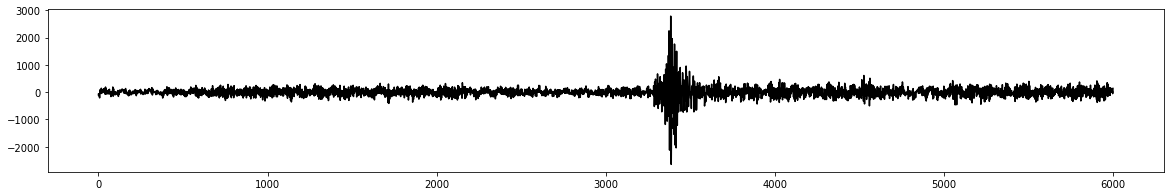

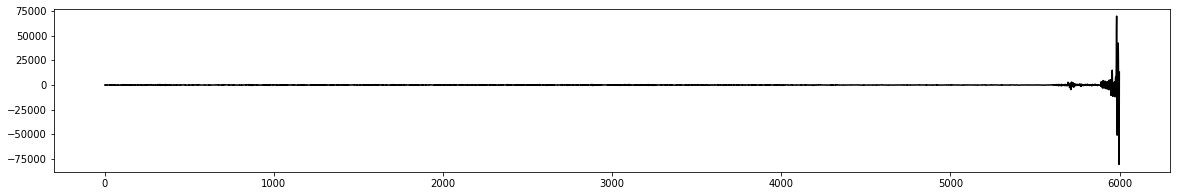

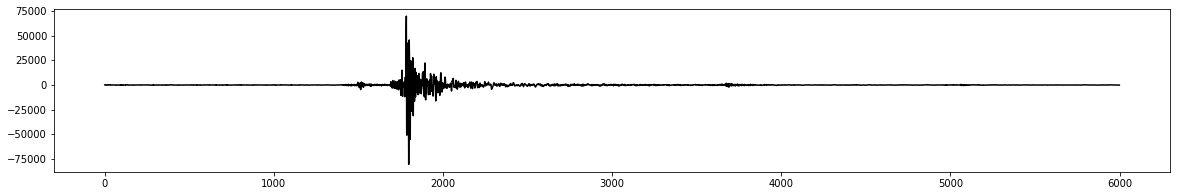

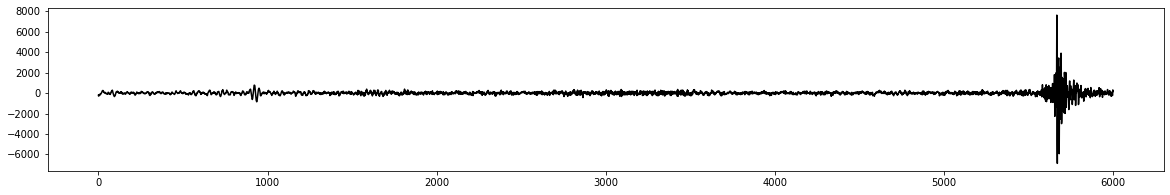

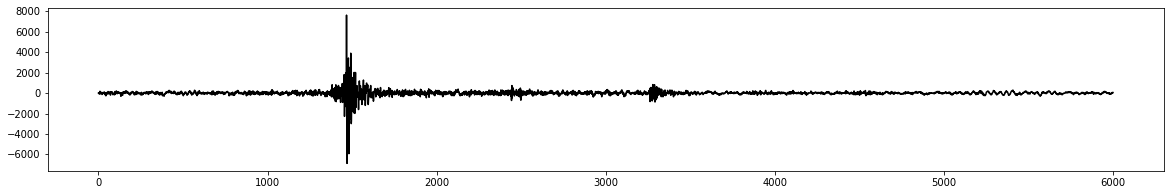

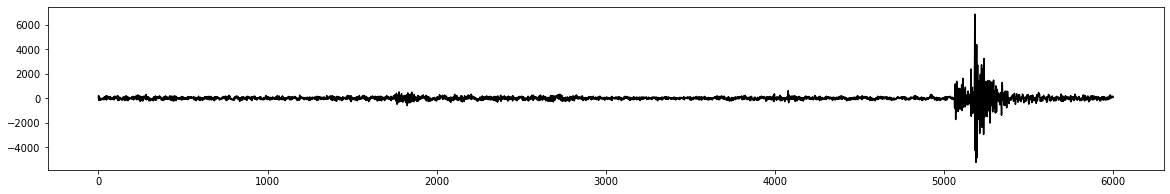

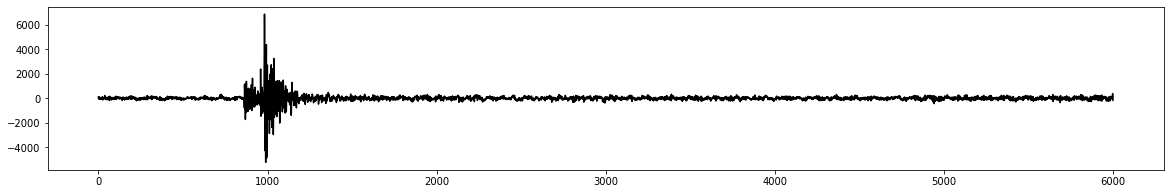

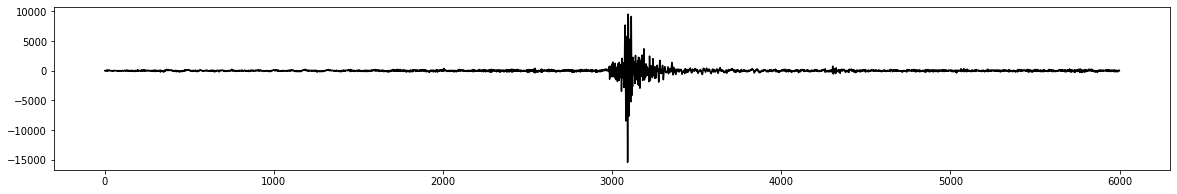

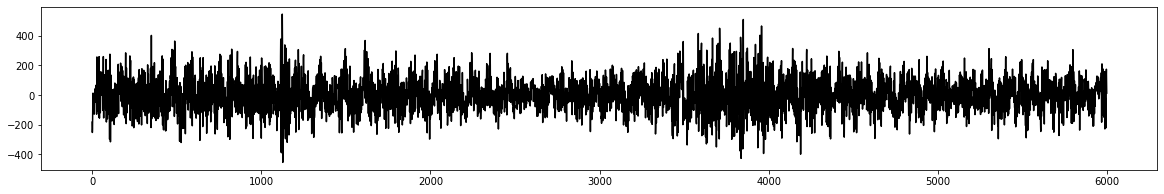

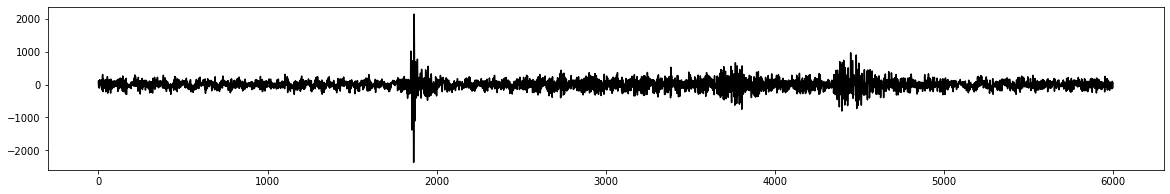

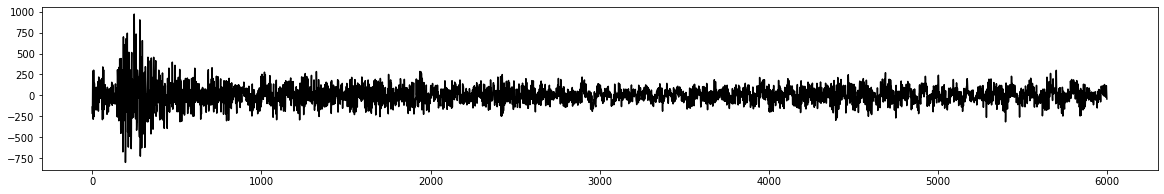

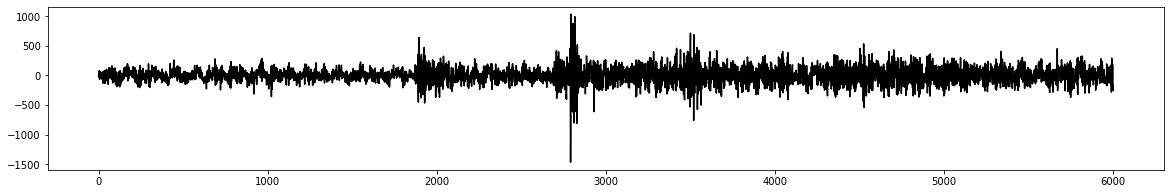

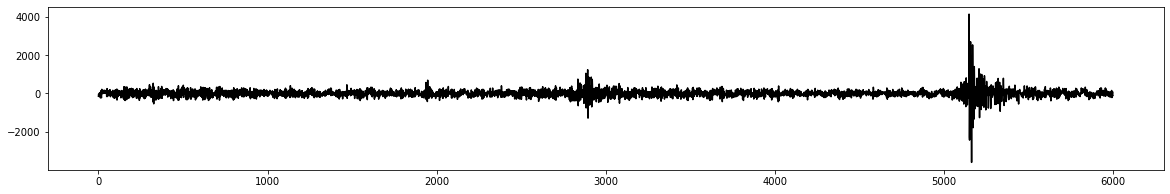

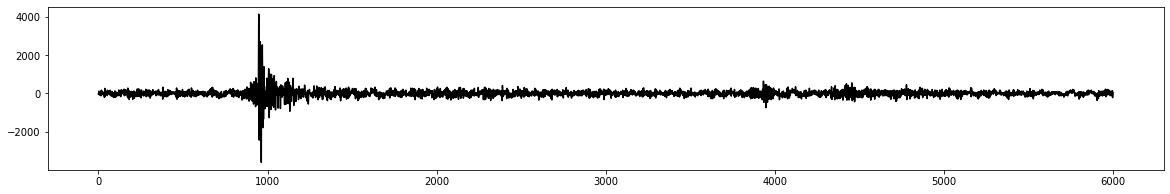

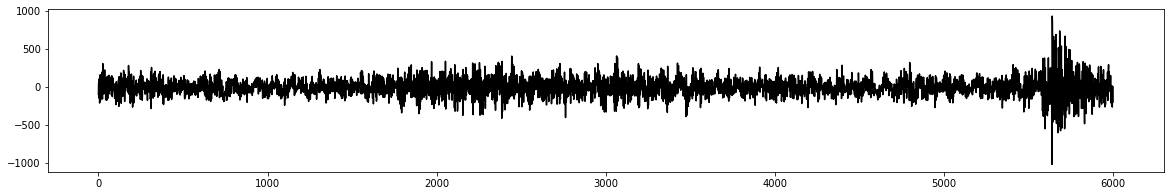

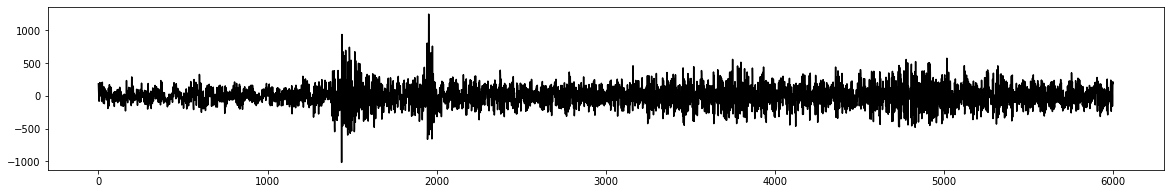

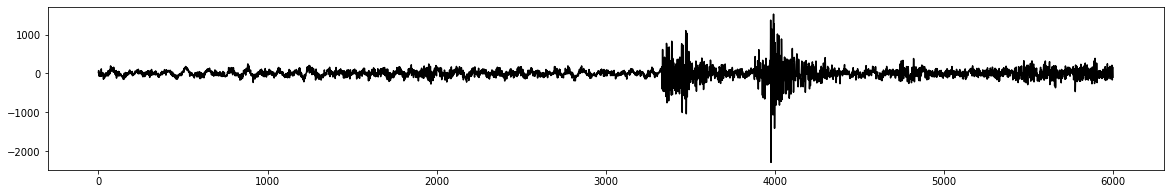

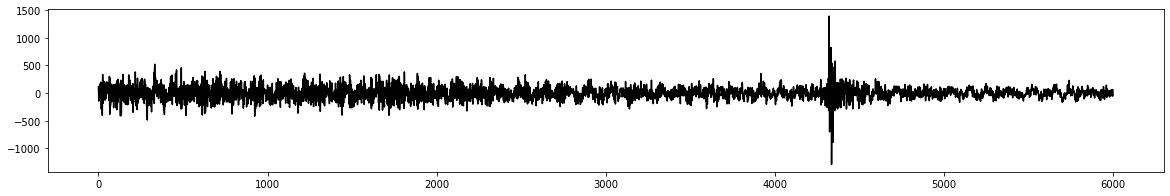

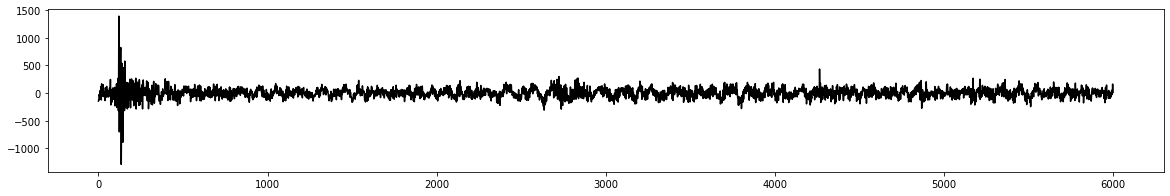

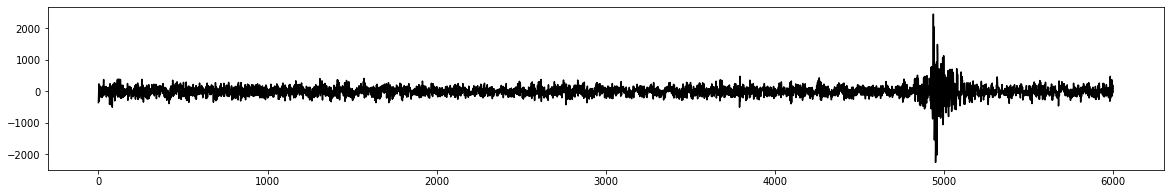

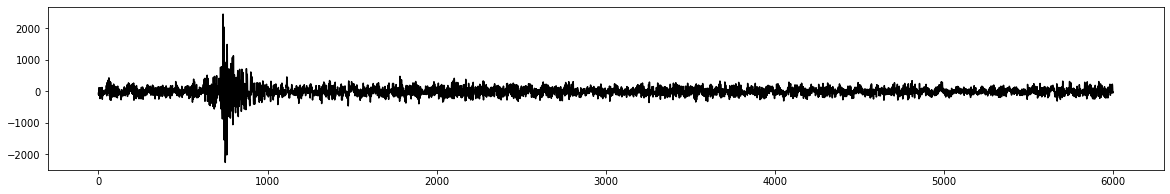

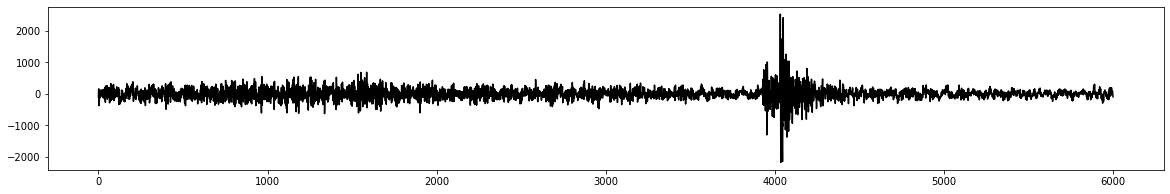

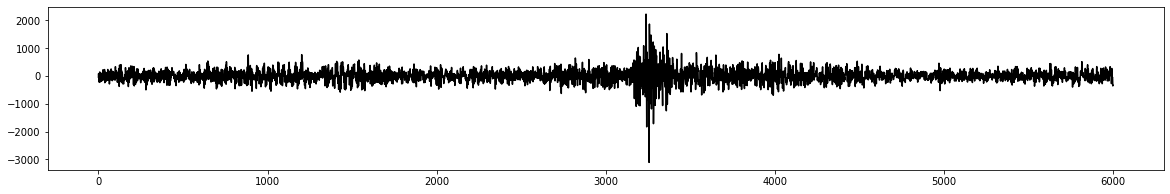

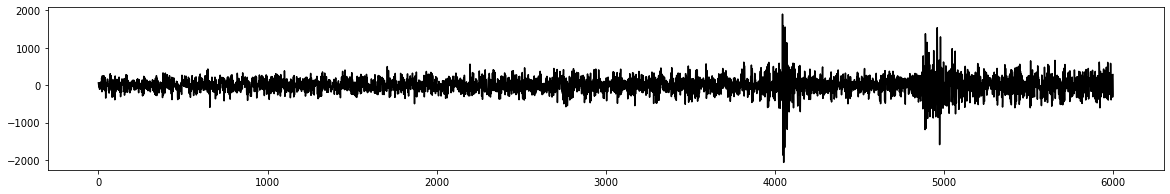

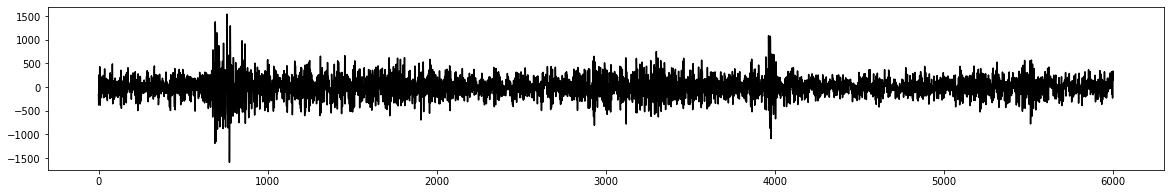

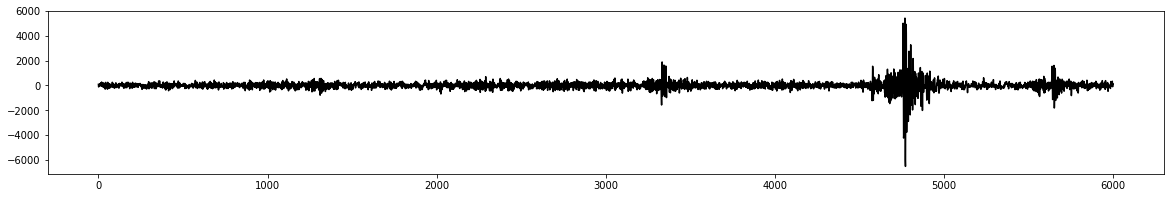

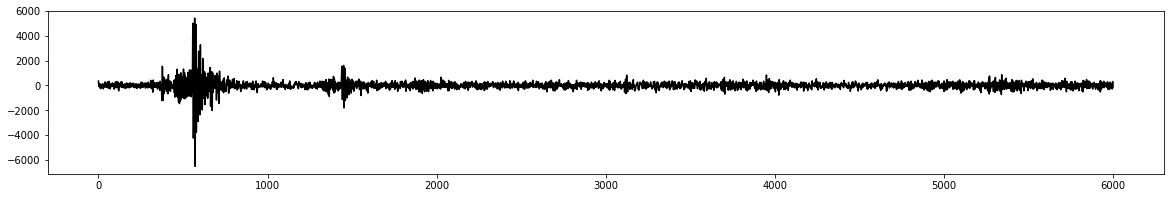

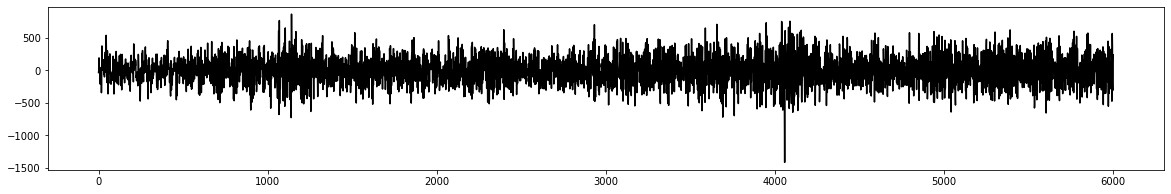

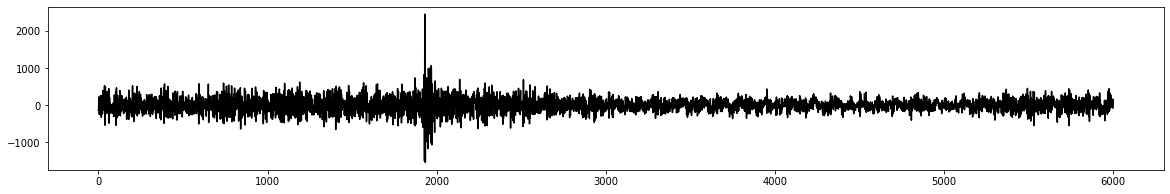

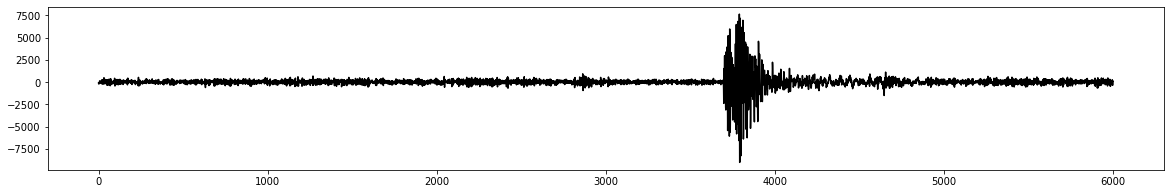

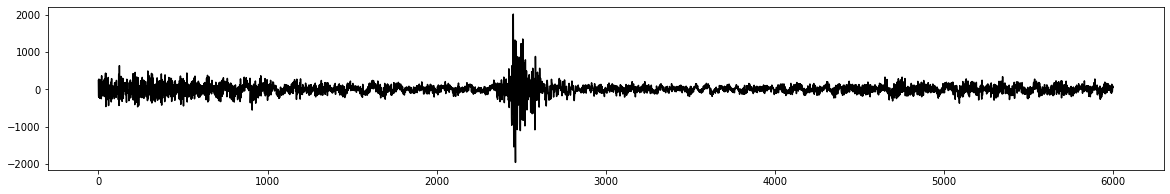

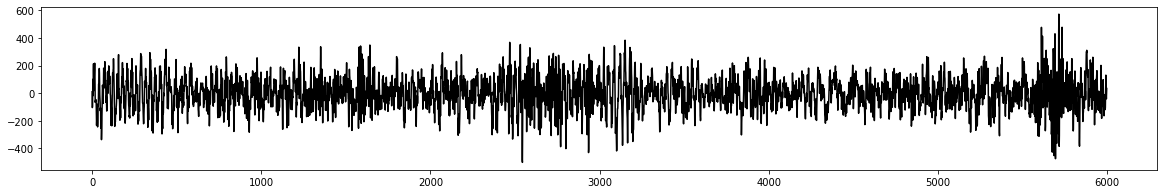

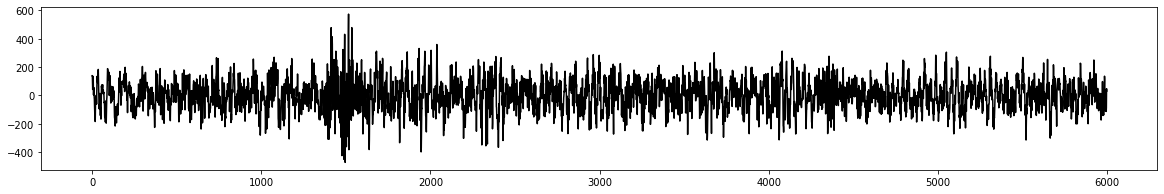

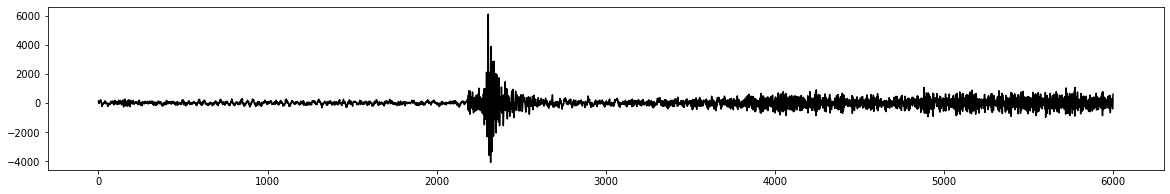

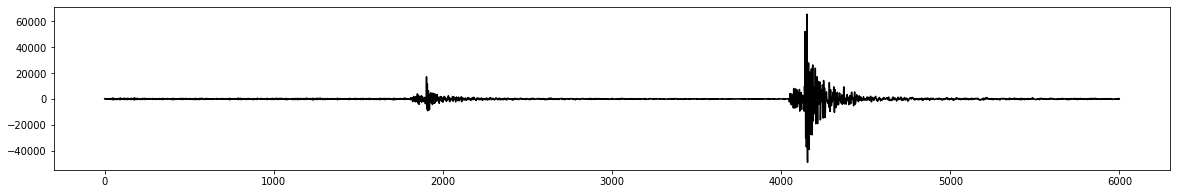

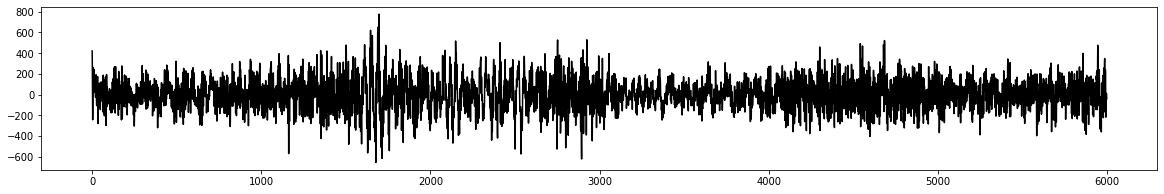

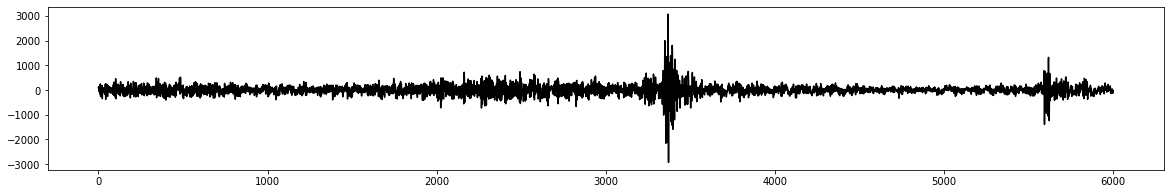

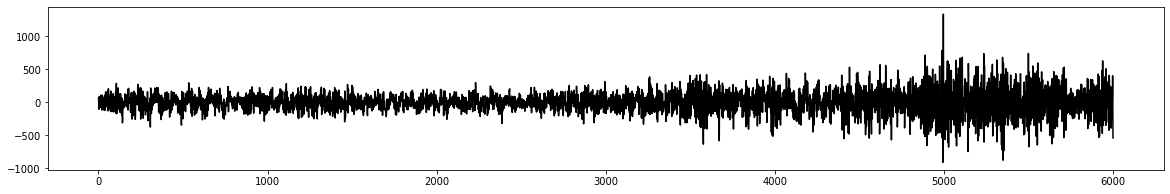

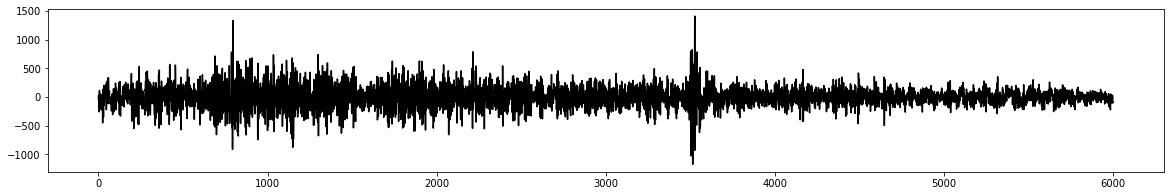

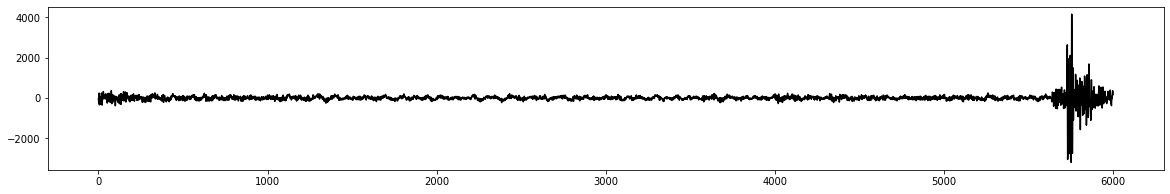

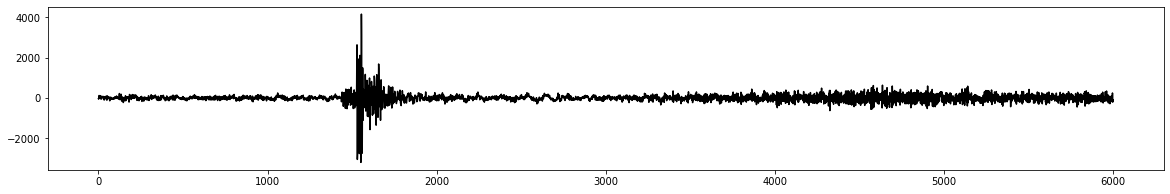

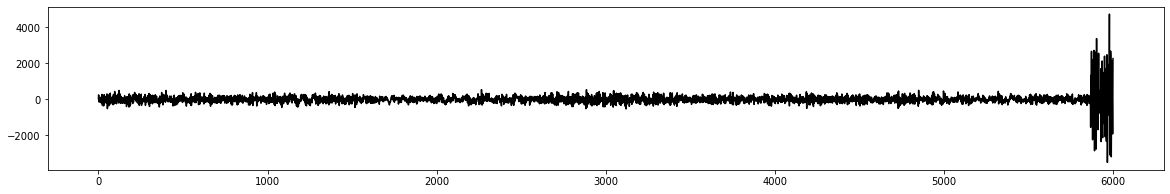

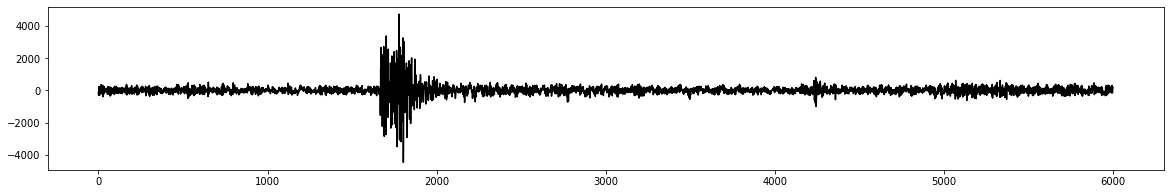

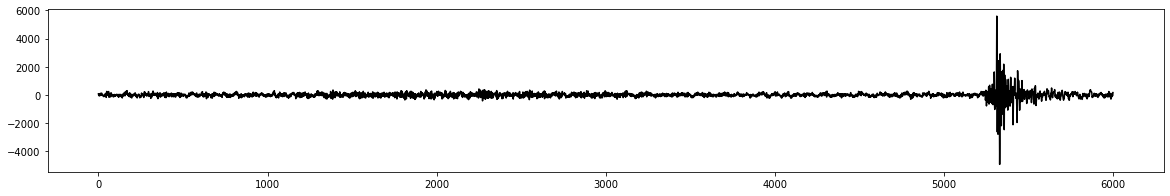

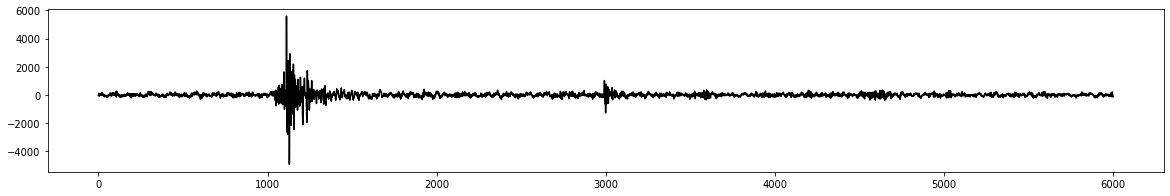

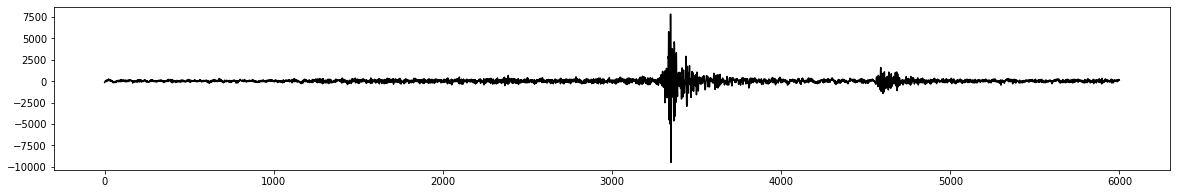

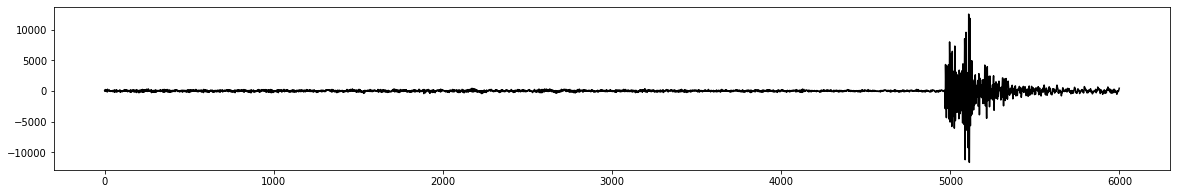

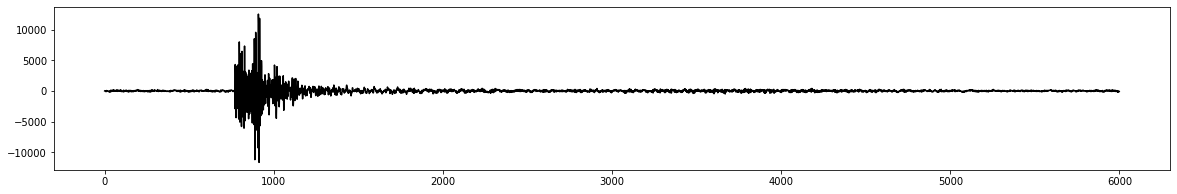

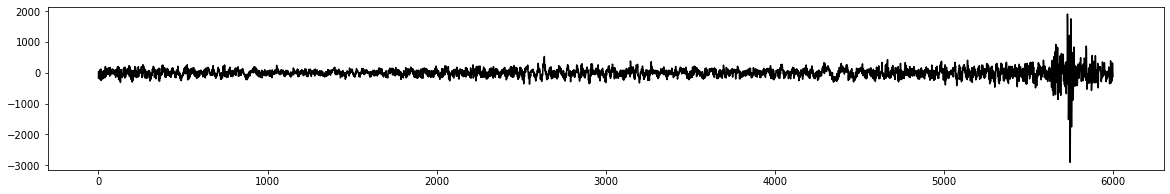

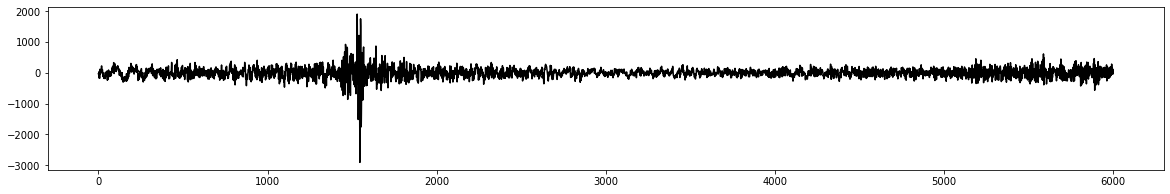

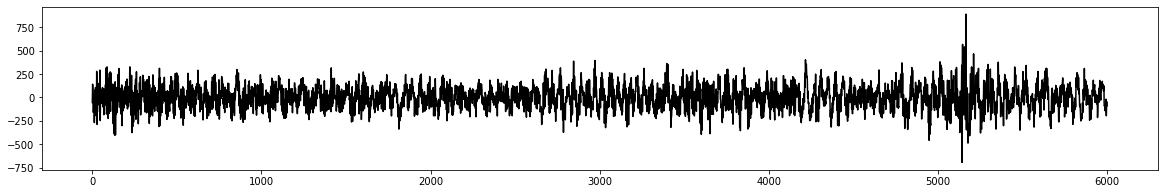

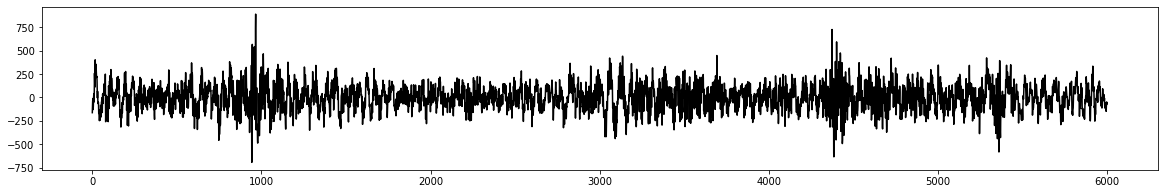

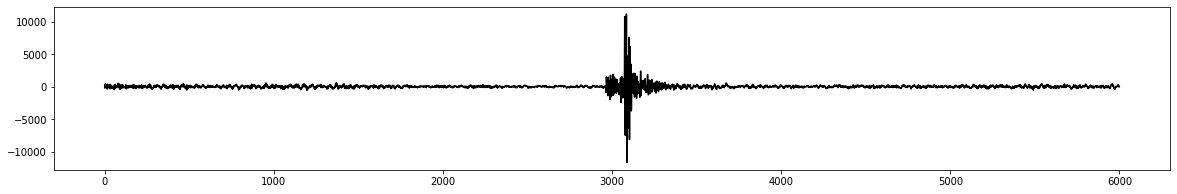

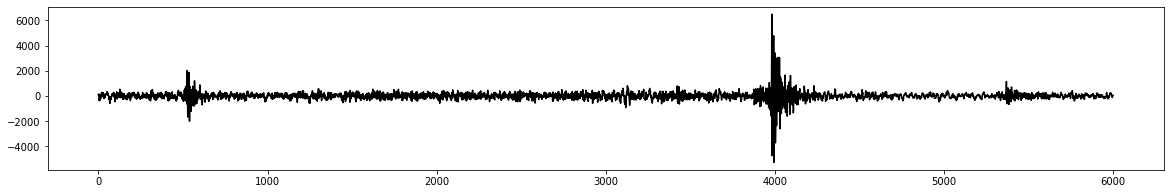

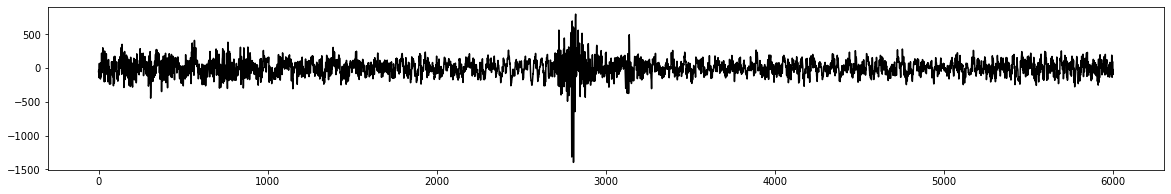

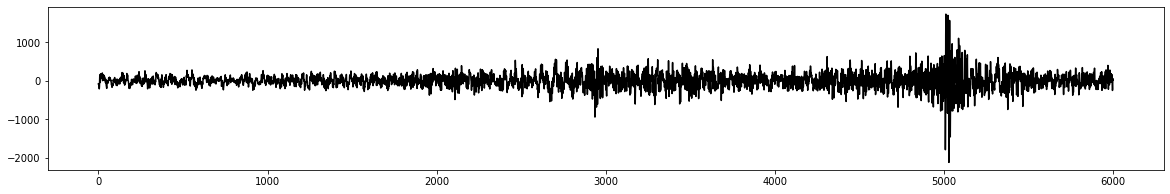

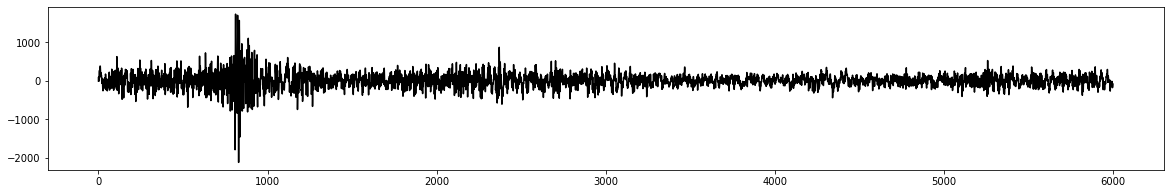

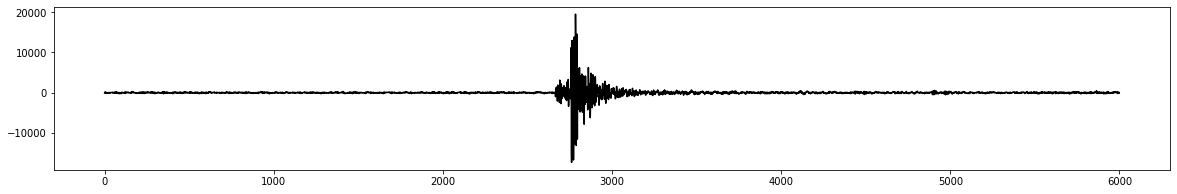

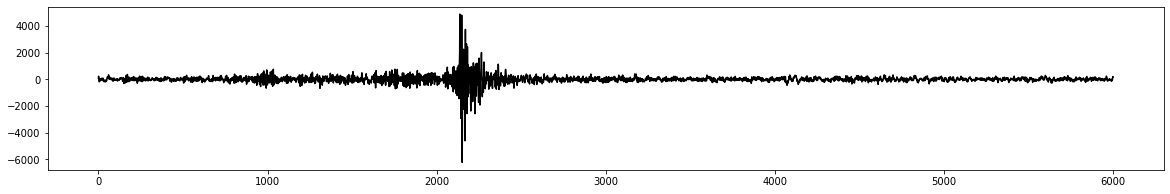

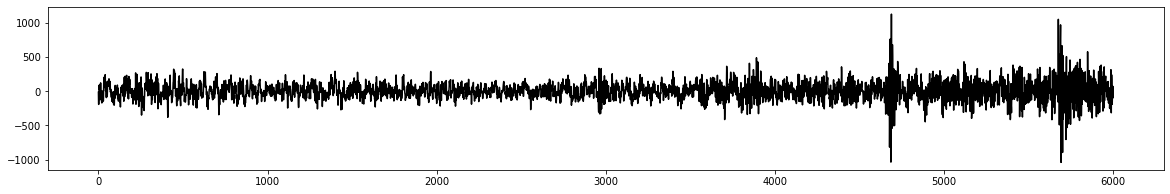

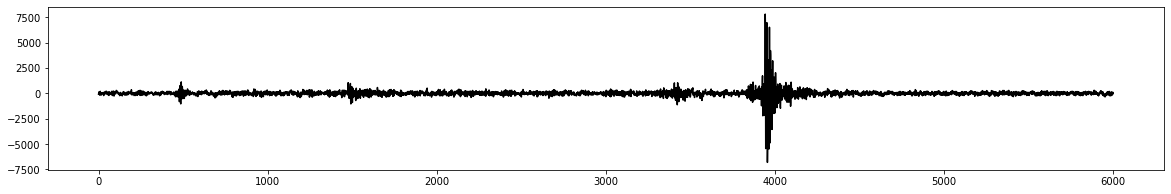

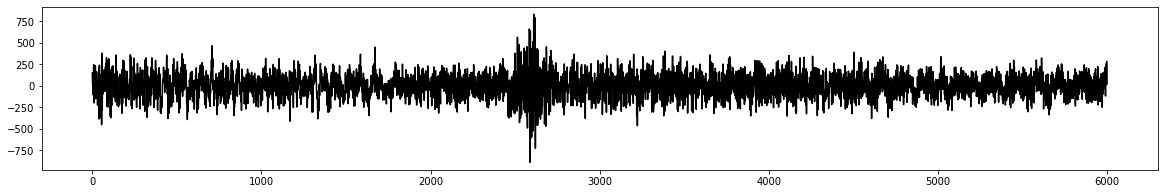

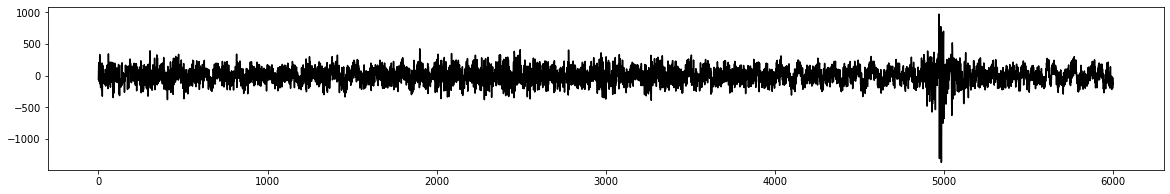

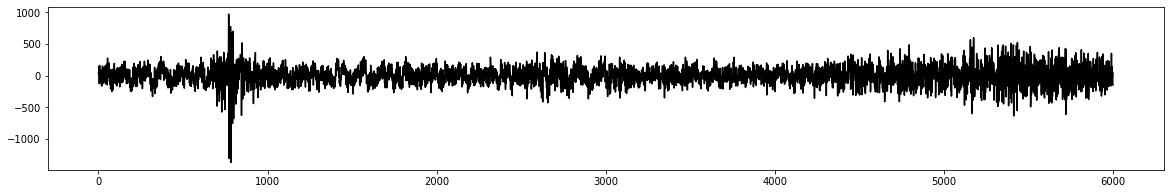

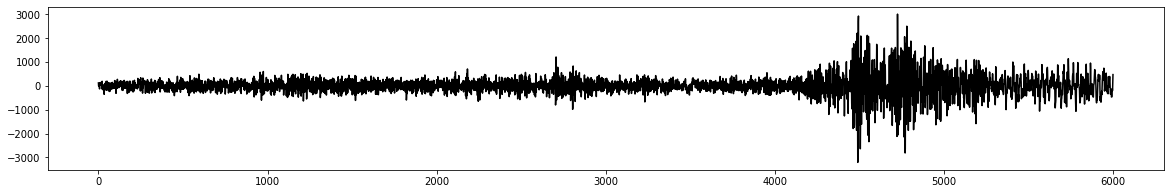

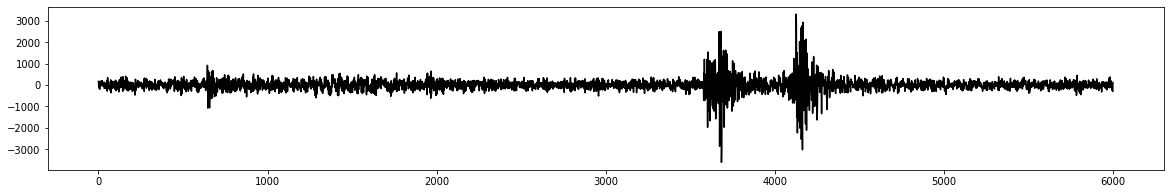

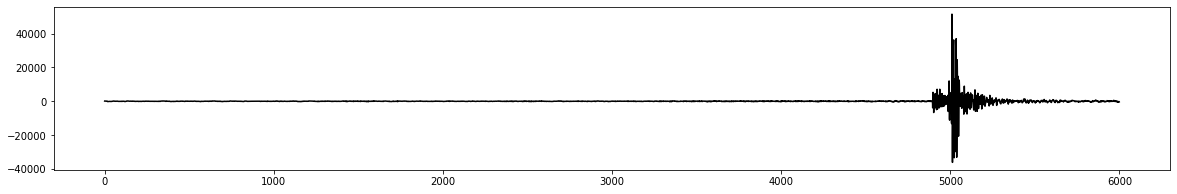

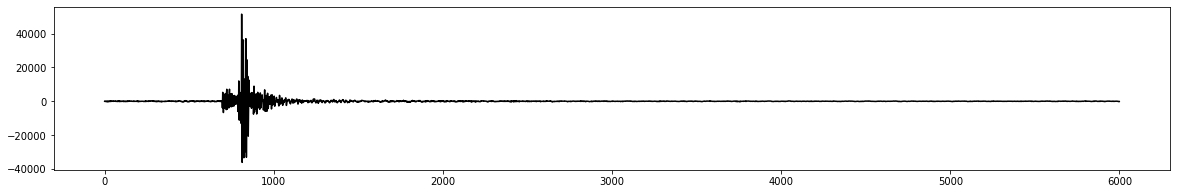

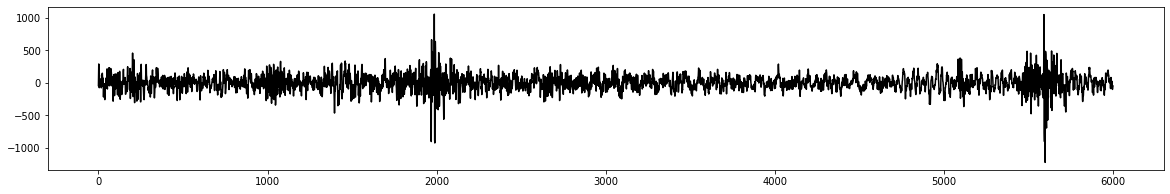

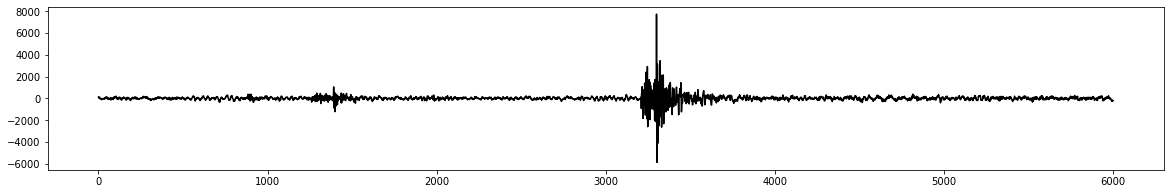

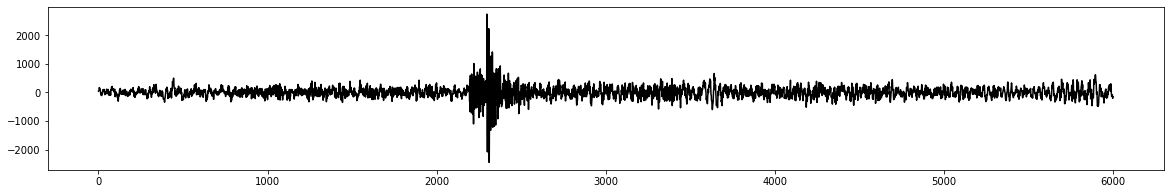

In [7]:
# import matplotlib.pyplot as plt

# for i in range(100):
#     plt.figure(figsize=(20,3))
#     plt.plot(data[t_data][i+298]['data'].T[0], color='black')
#     plt.show()

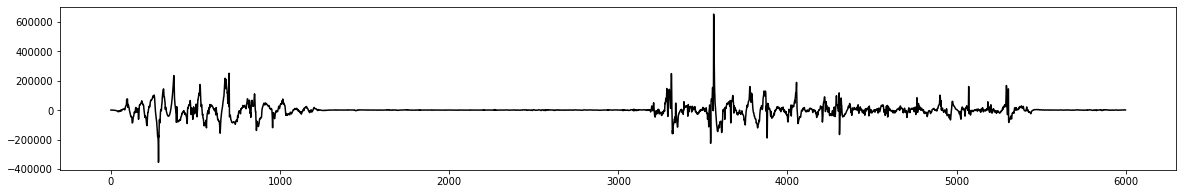

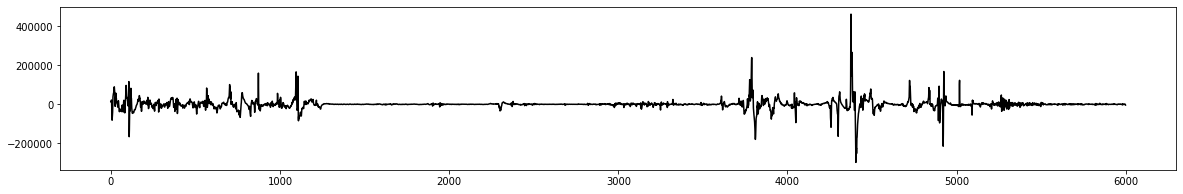

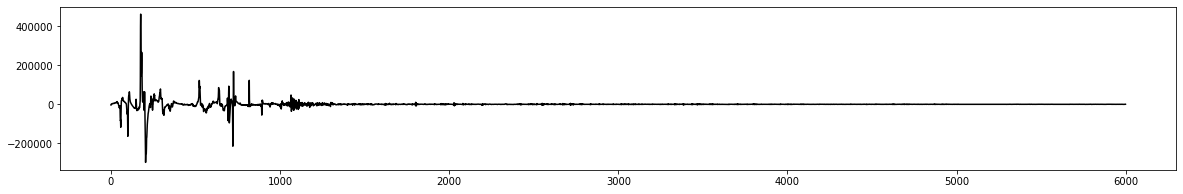

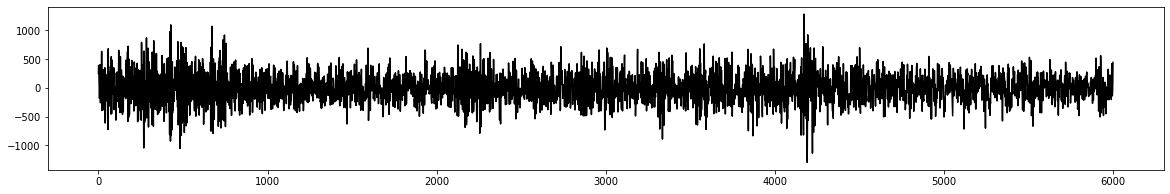

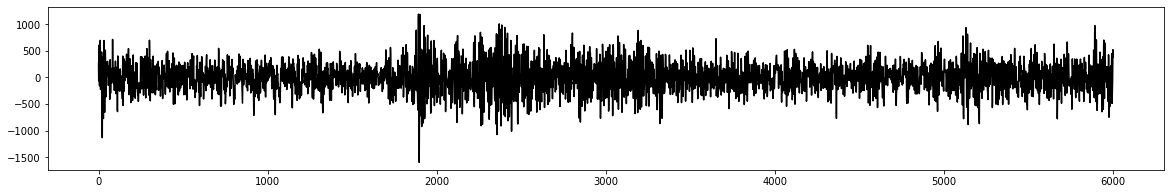

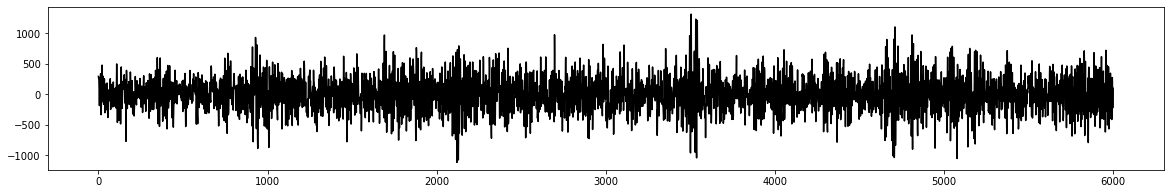

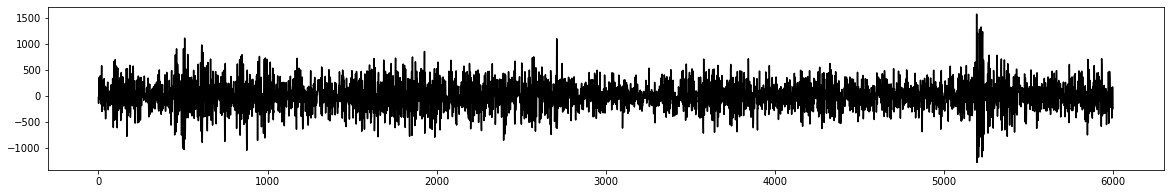

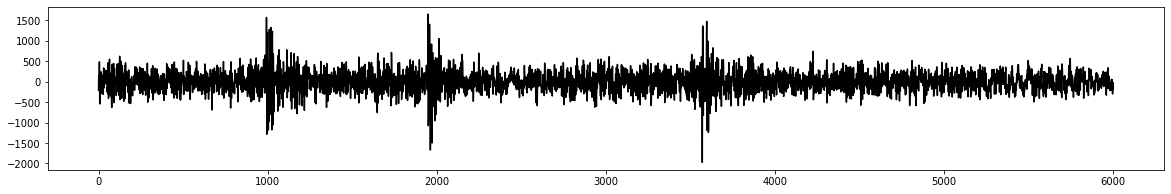

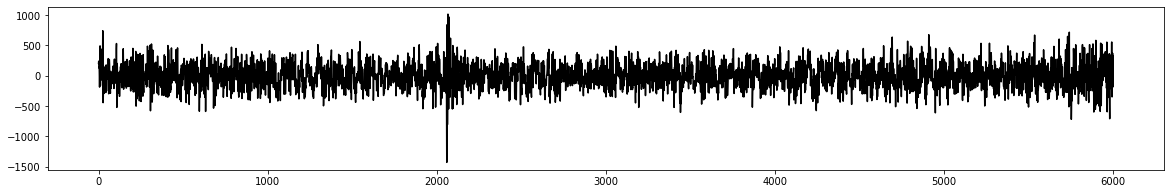

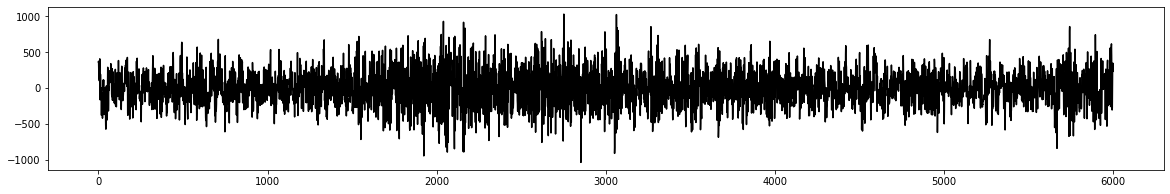

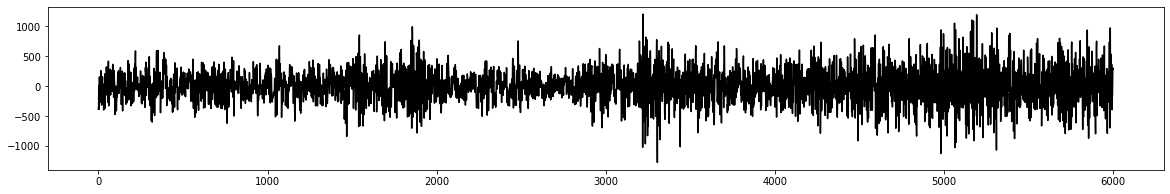

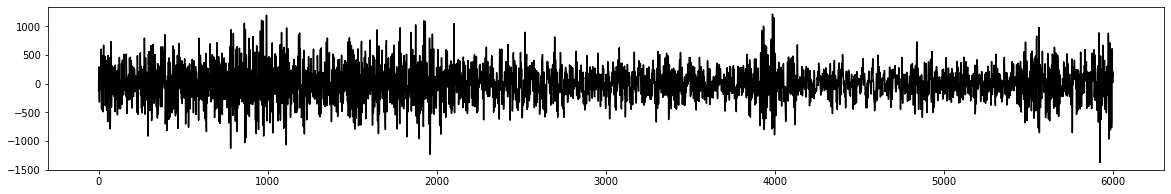

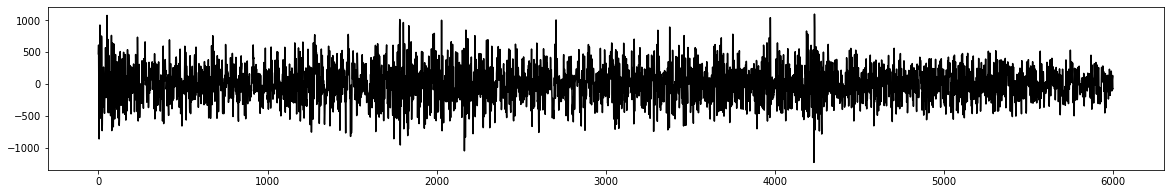

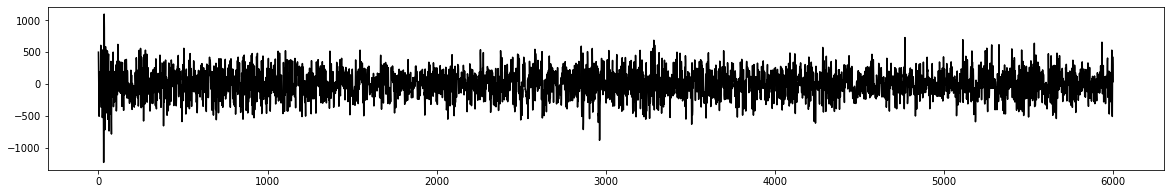

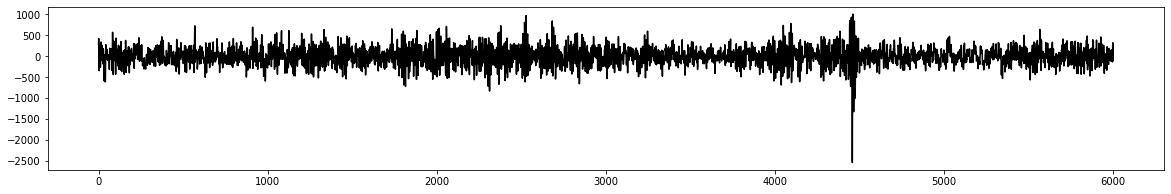

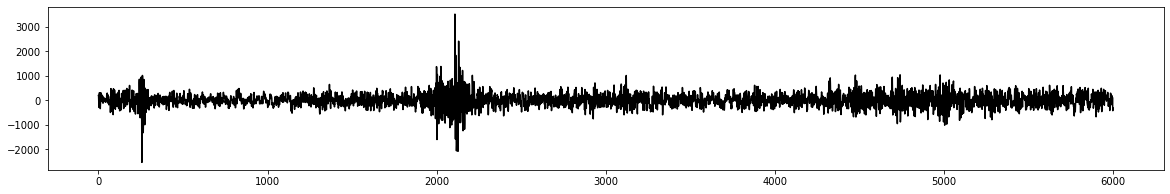

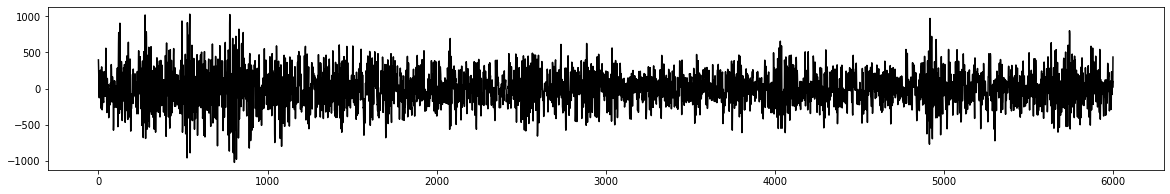

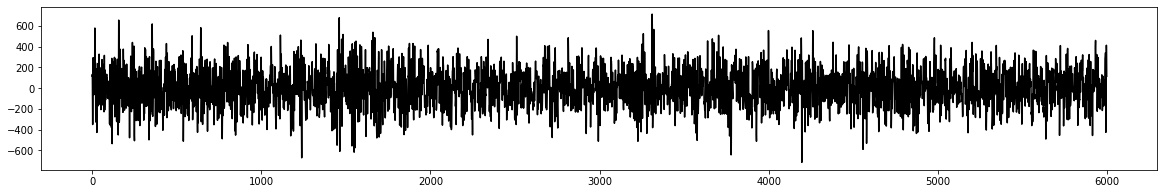

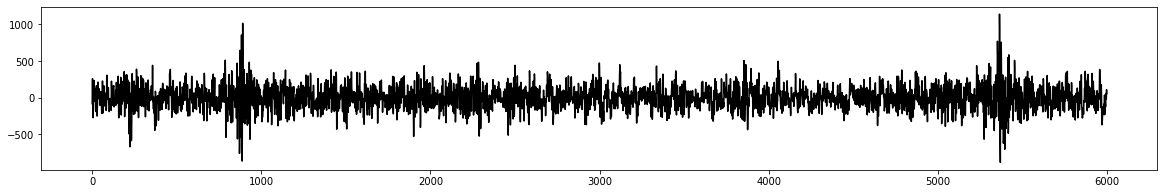

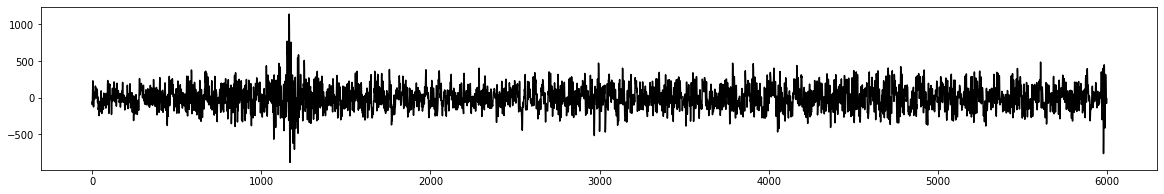

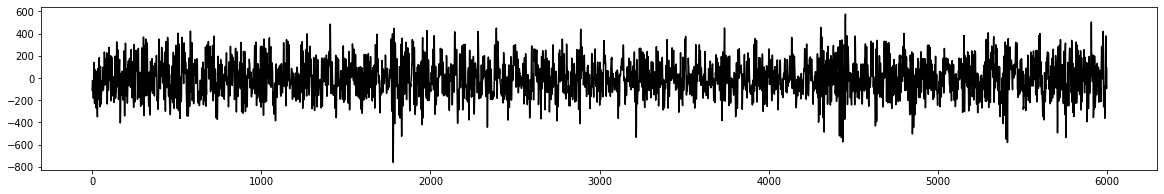

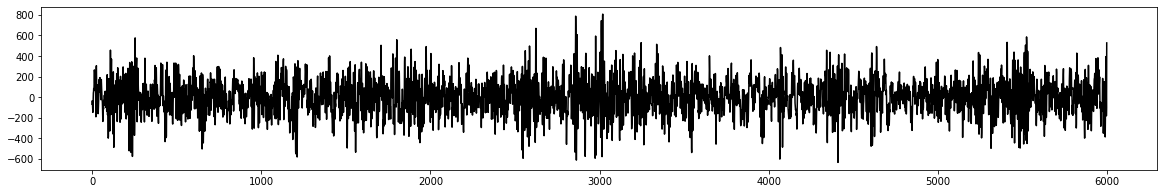

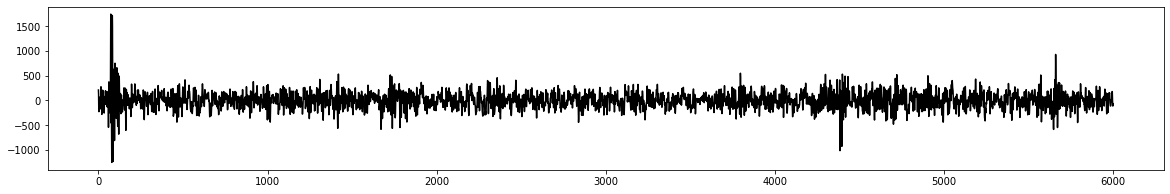

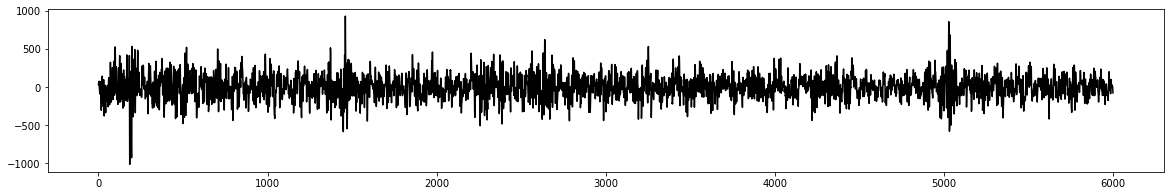

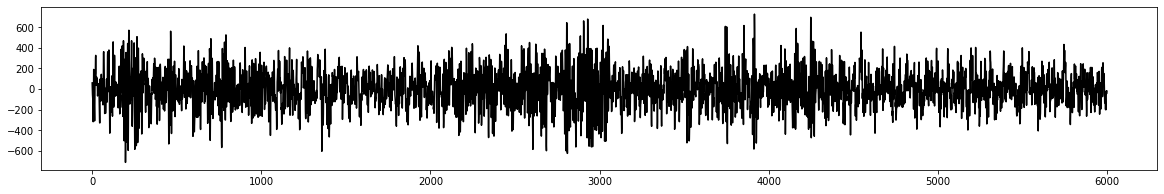

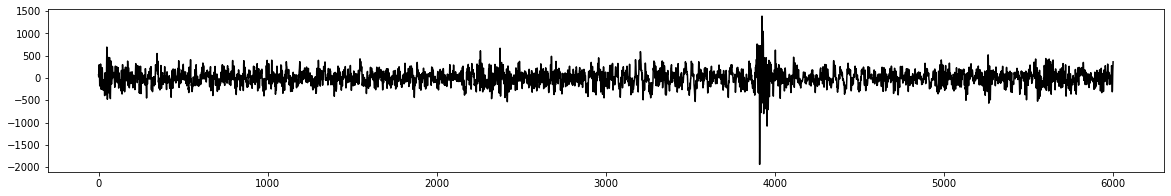

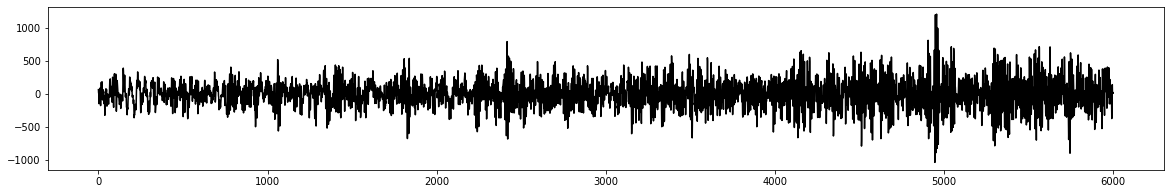

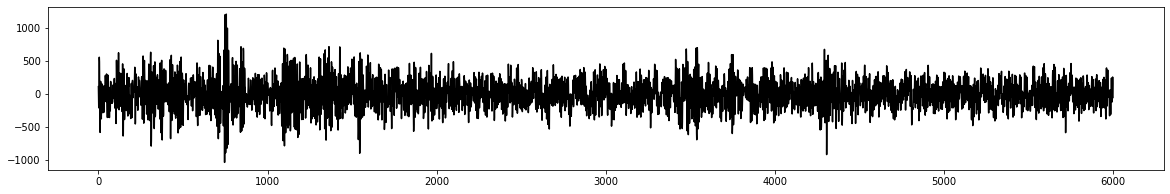

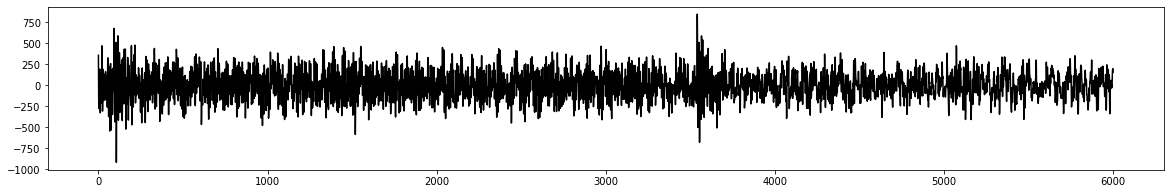

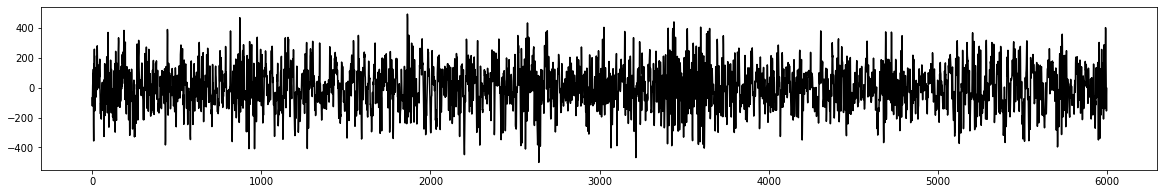

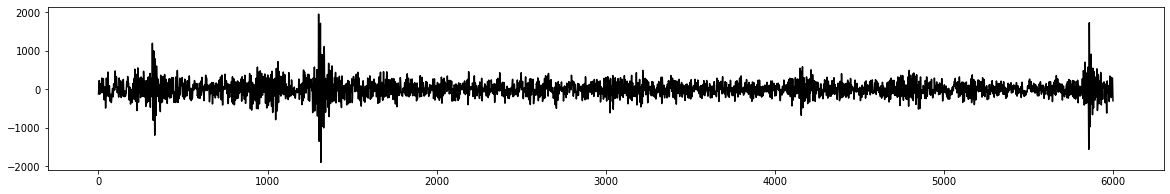

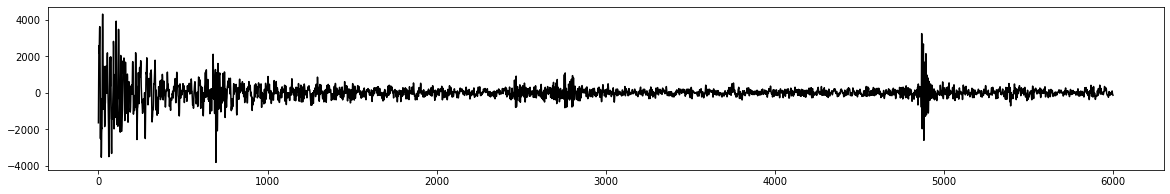

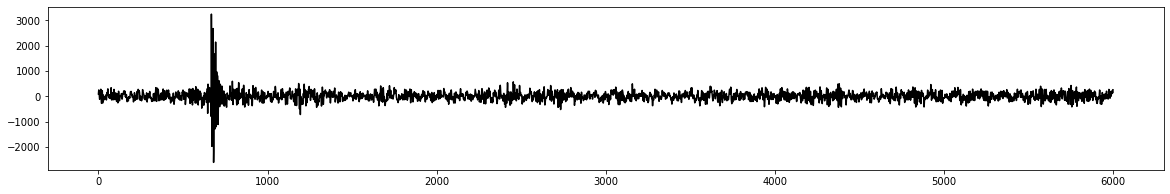

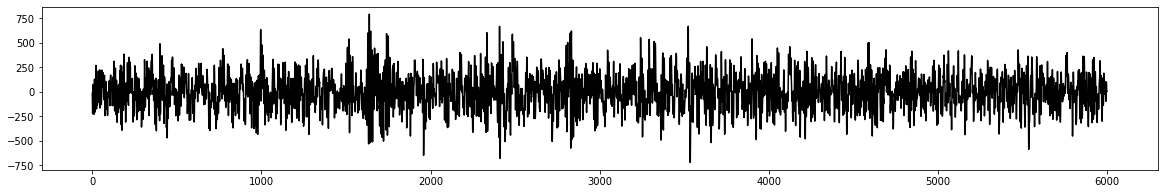

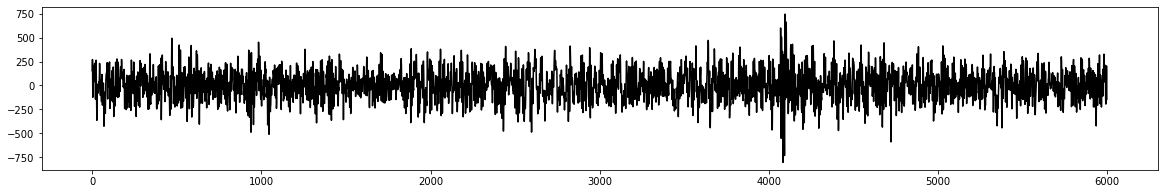

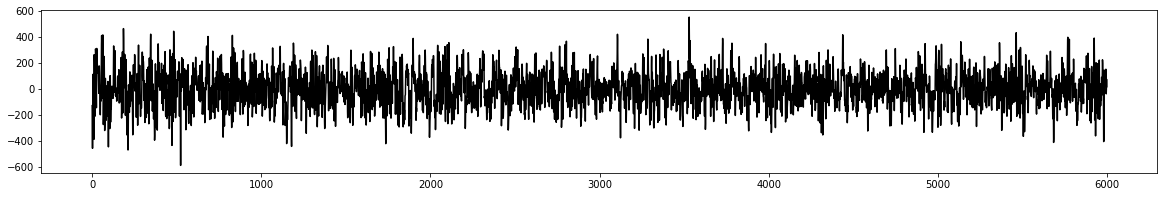

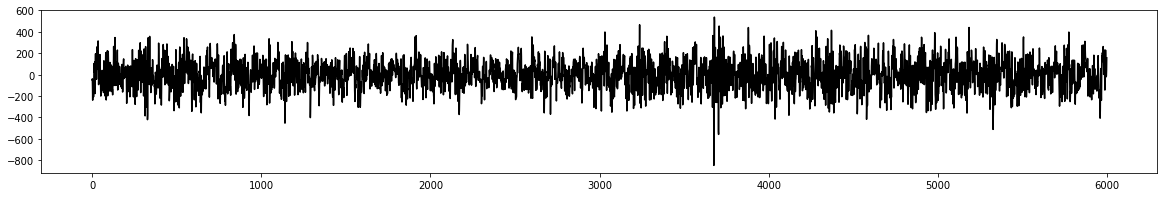

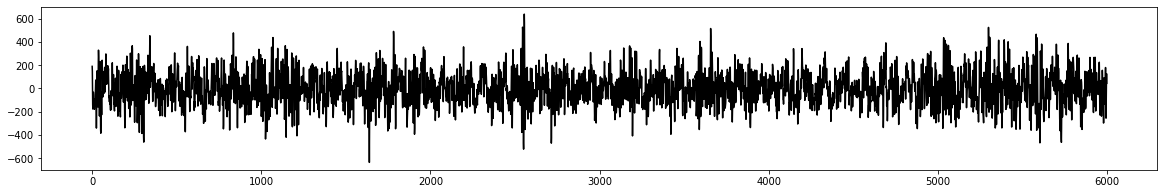

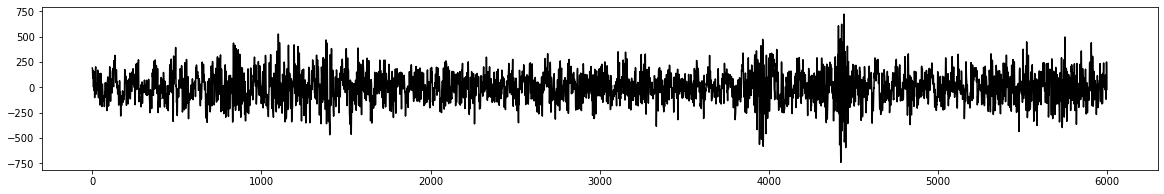

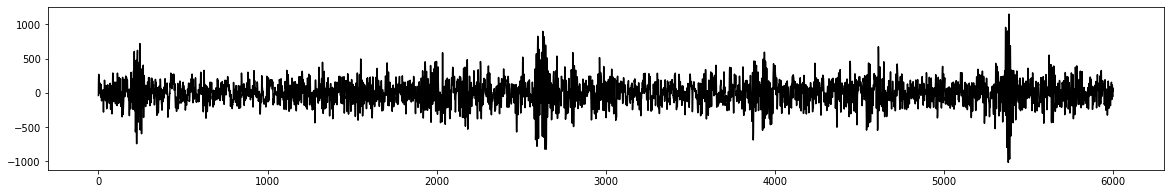

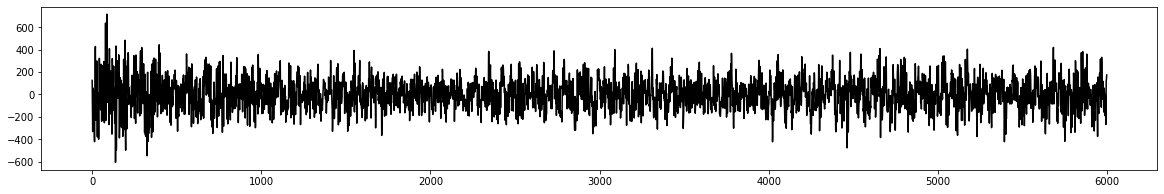

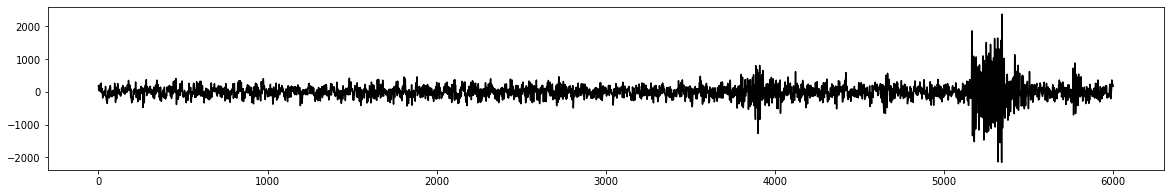

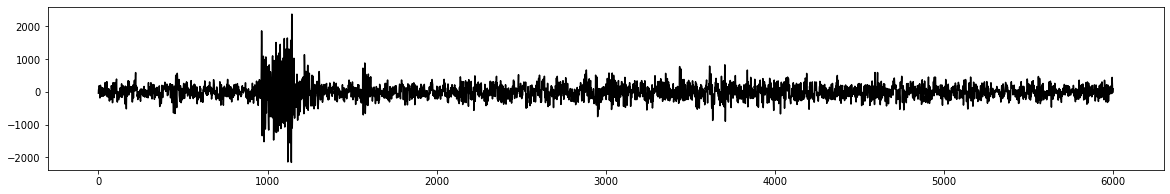

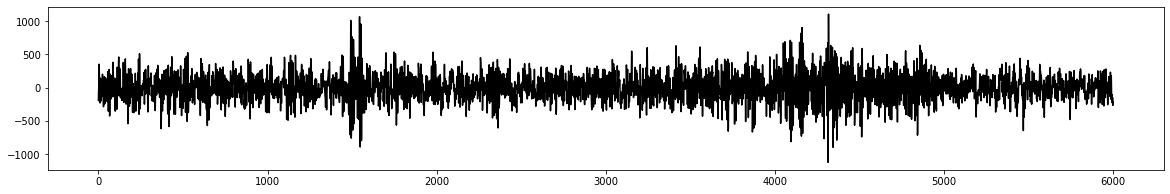

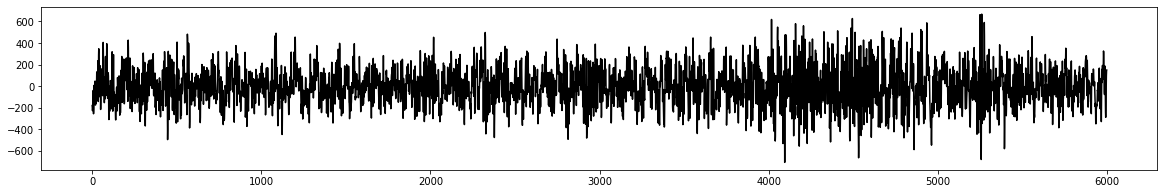

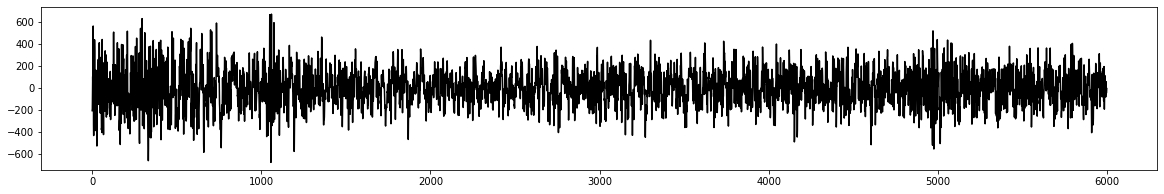

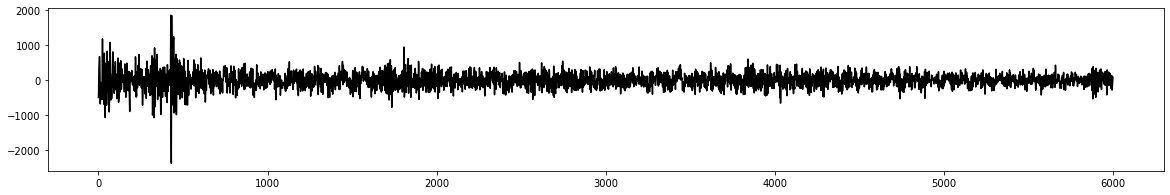

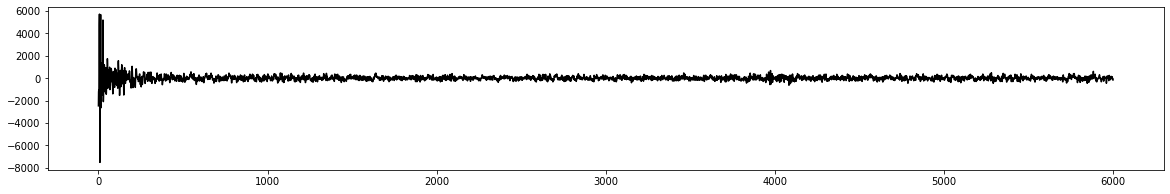

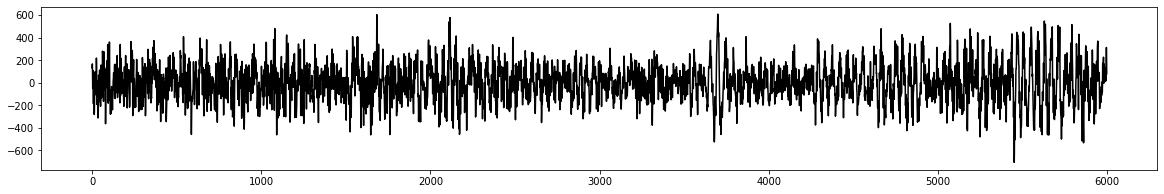

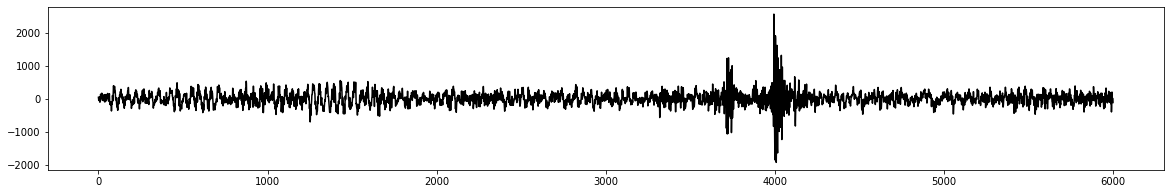

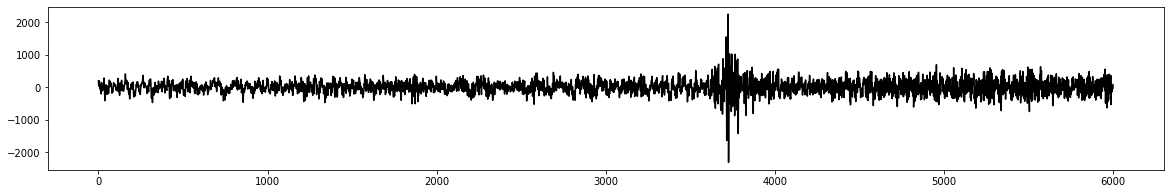

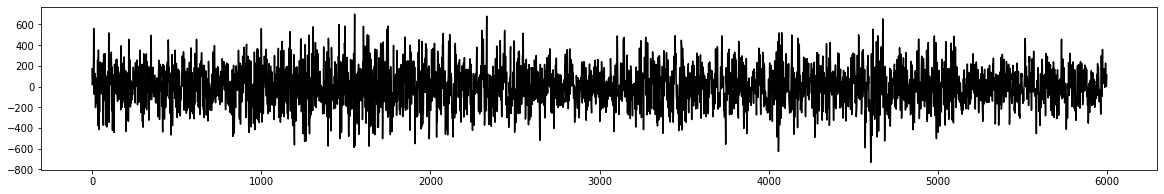

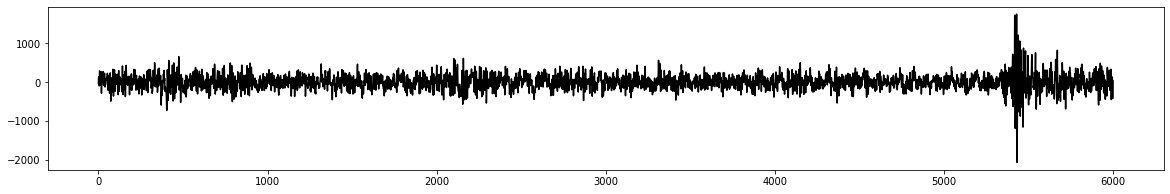

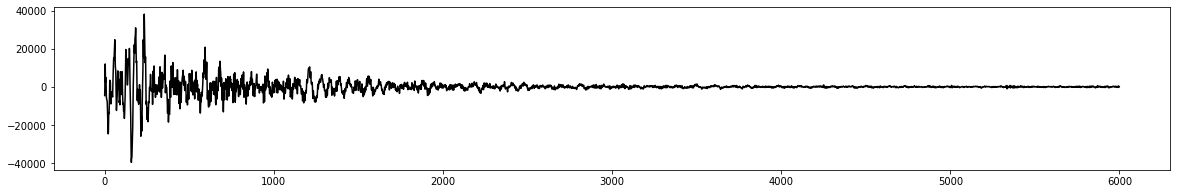

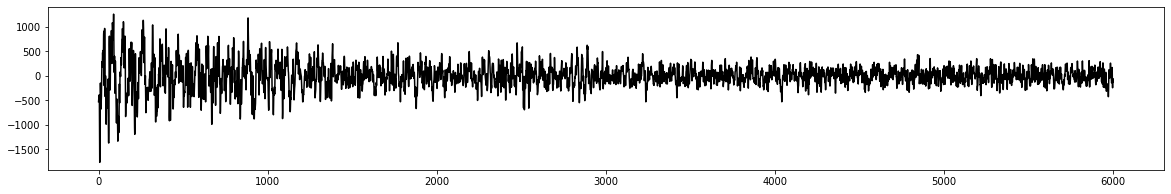

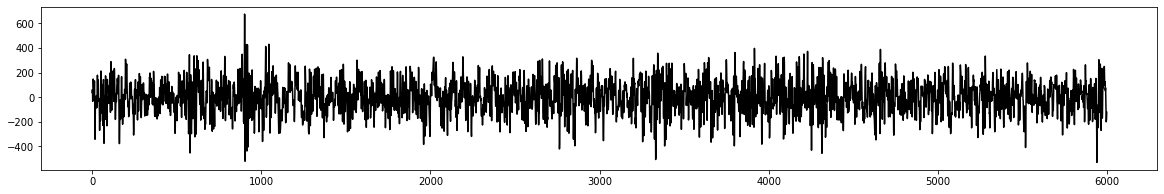

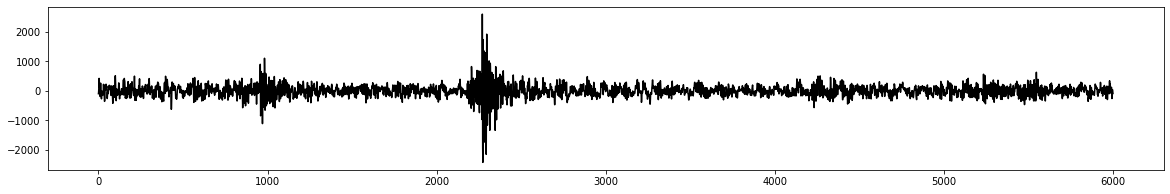

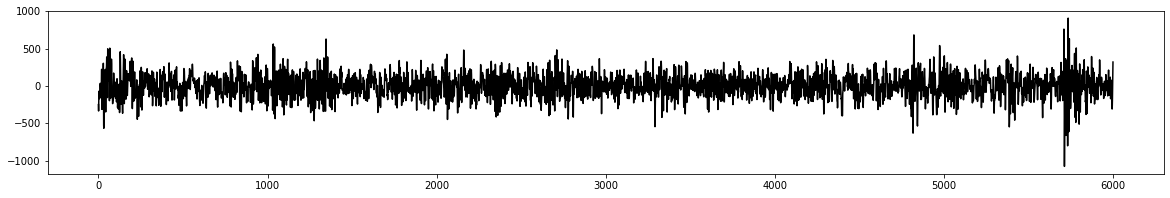

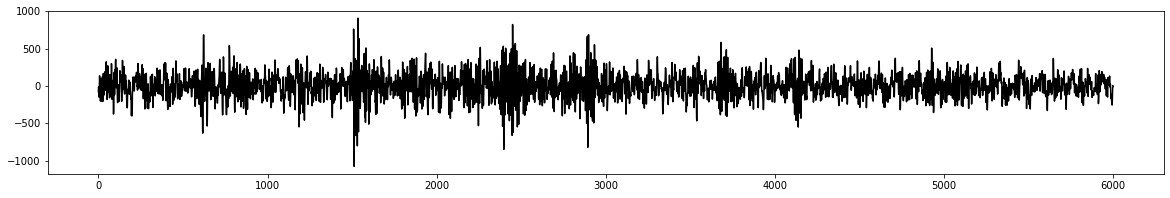

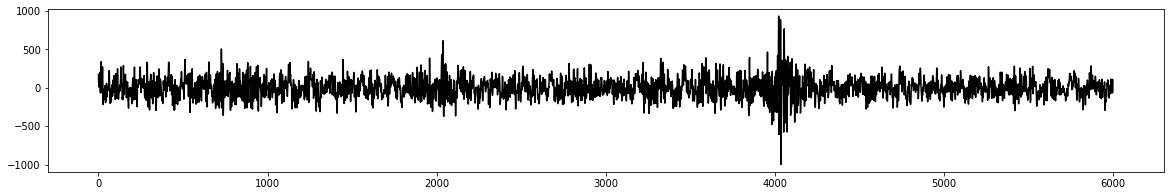

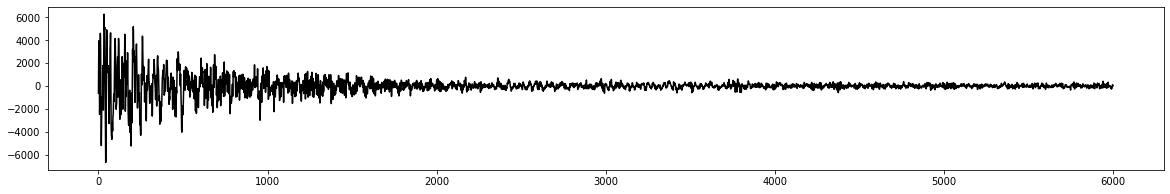

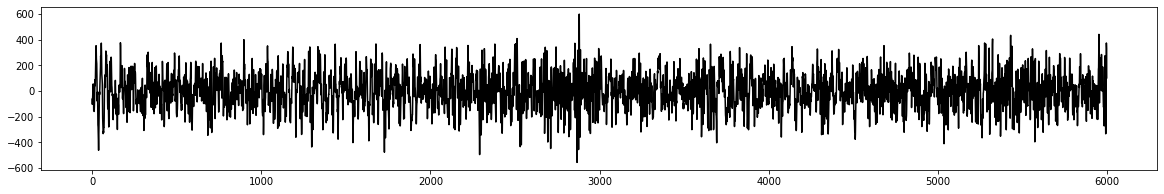

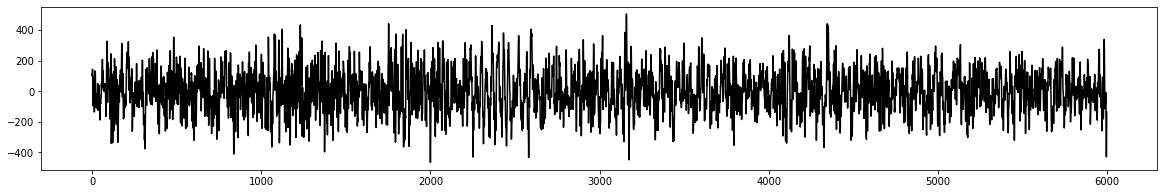

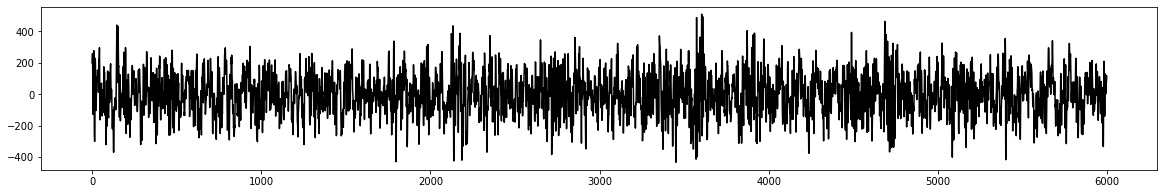

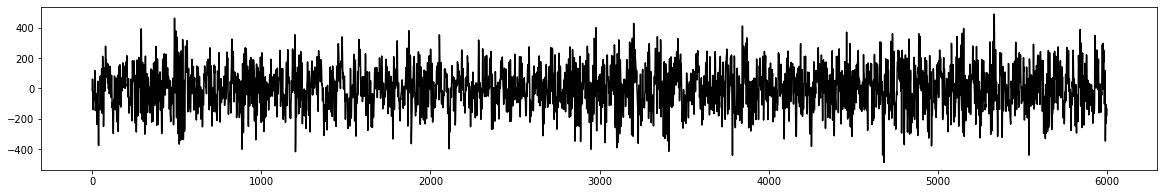

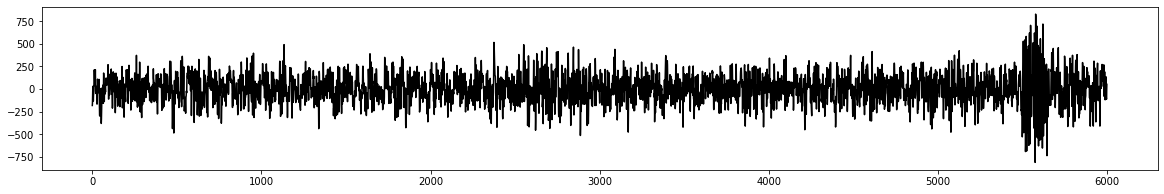

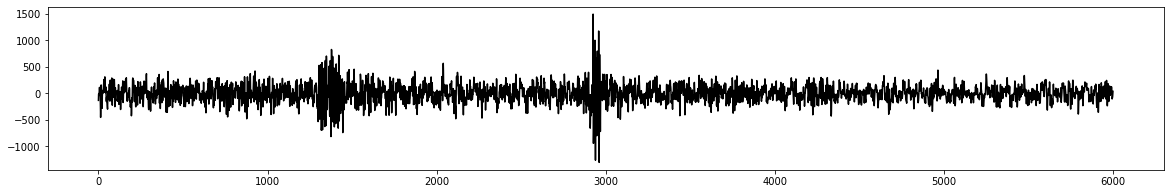

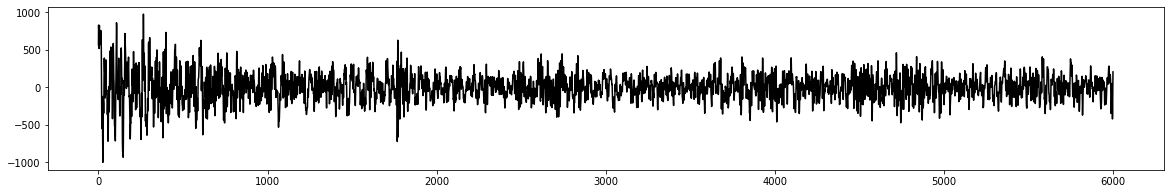

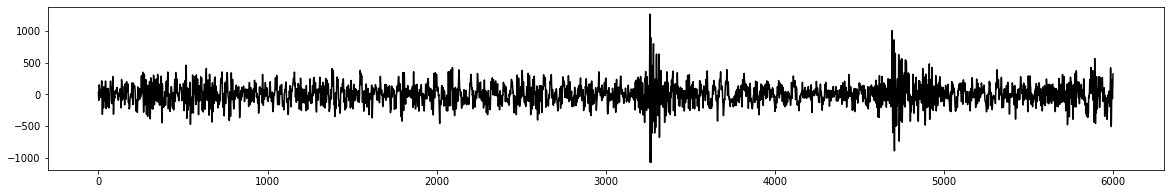

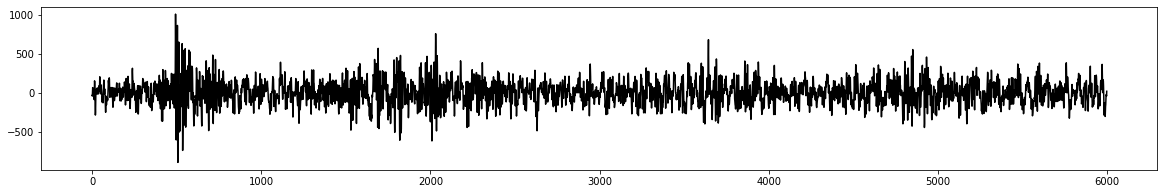

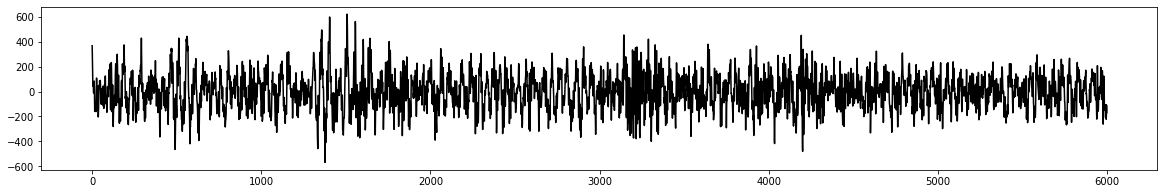

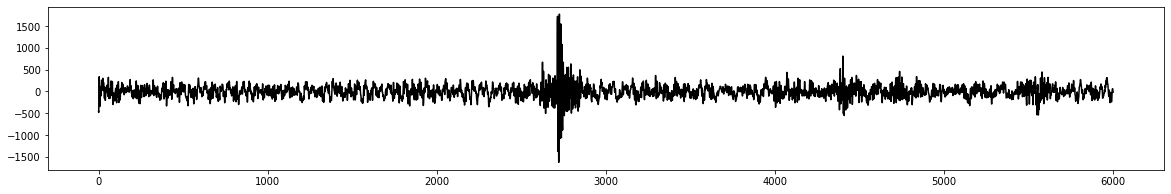

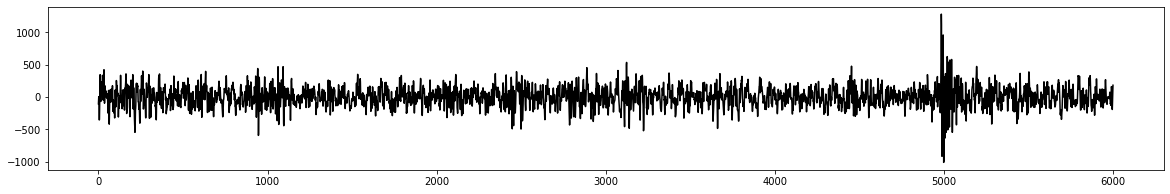

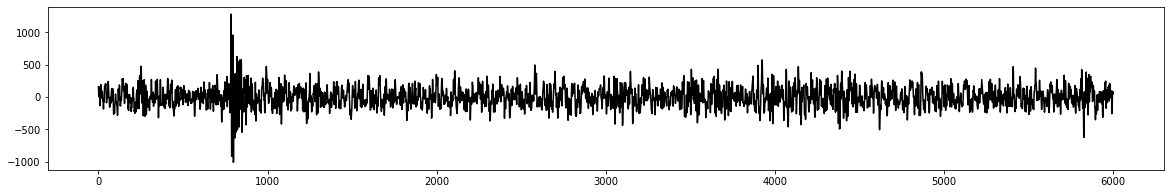

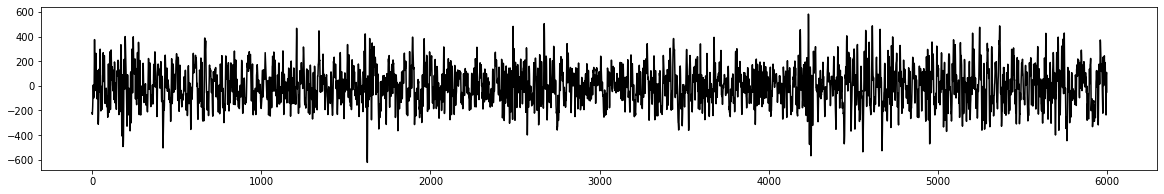

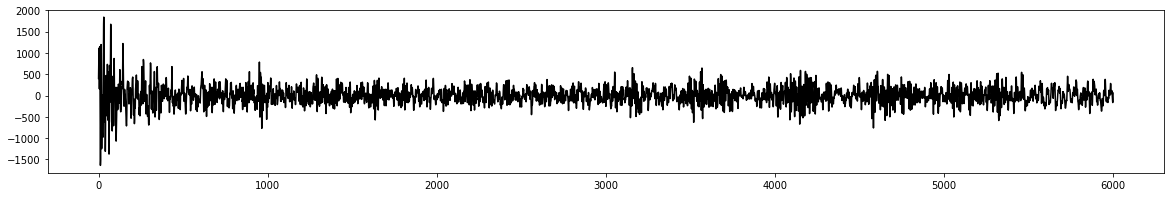

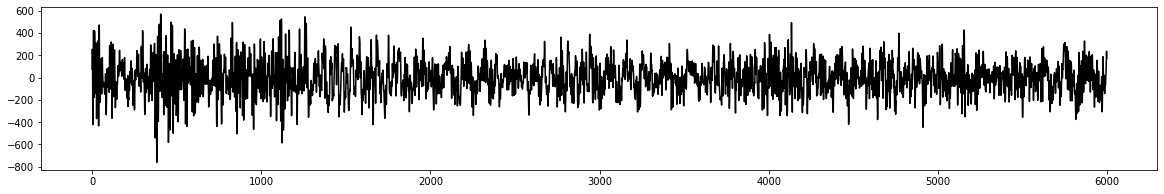

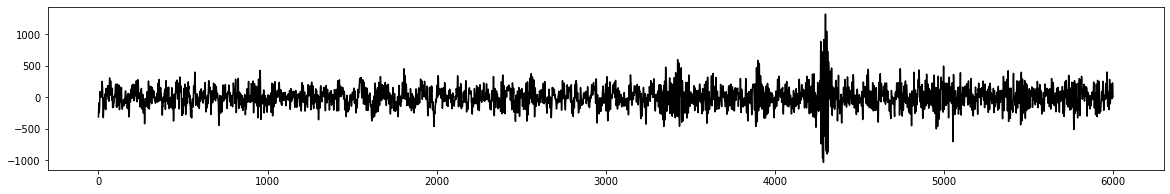

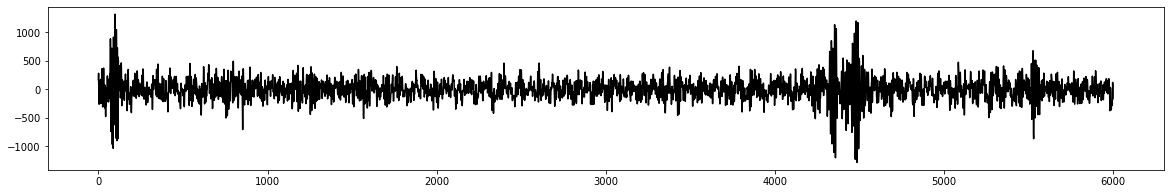

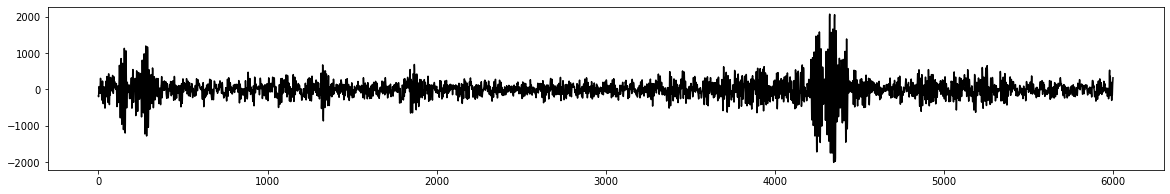

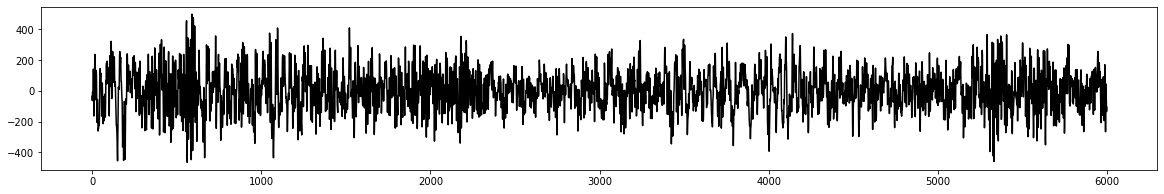

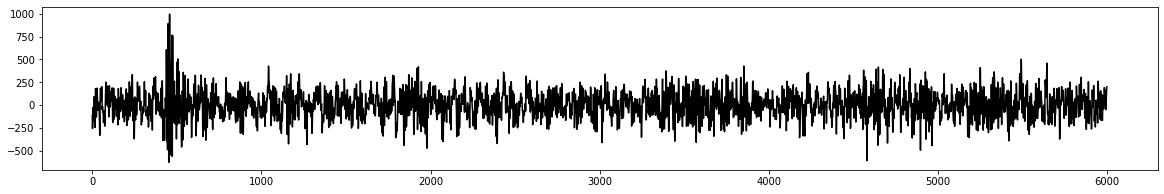

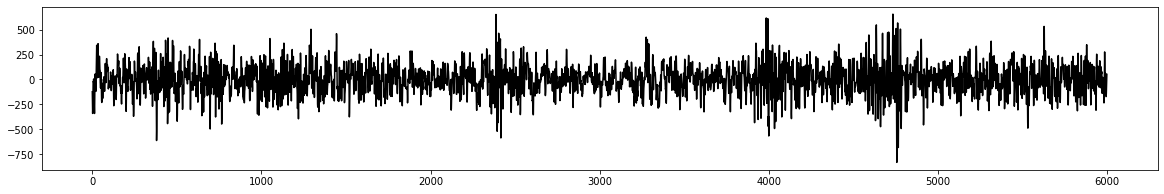

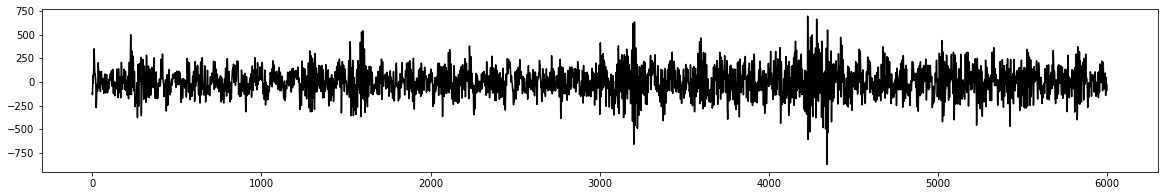

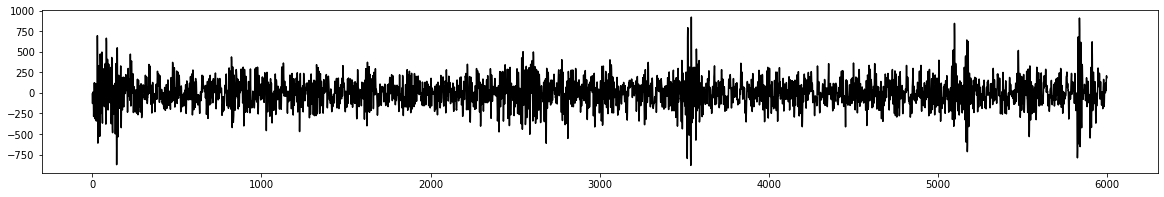

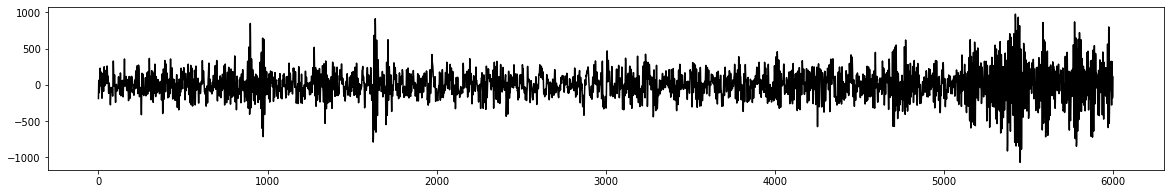

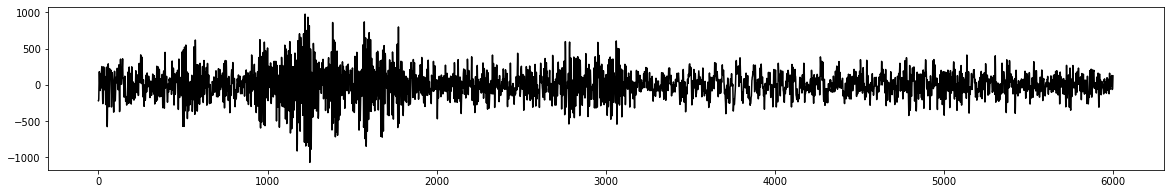

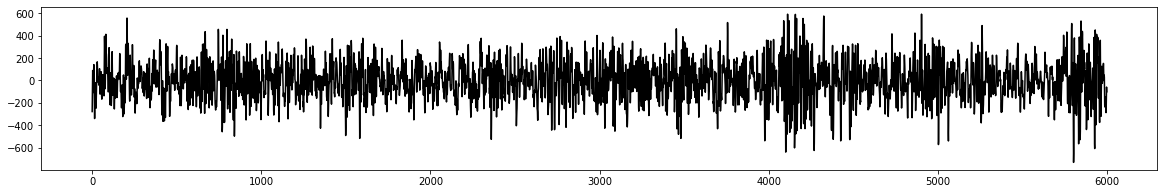

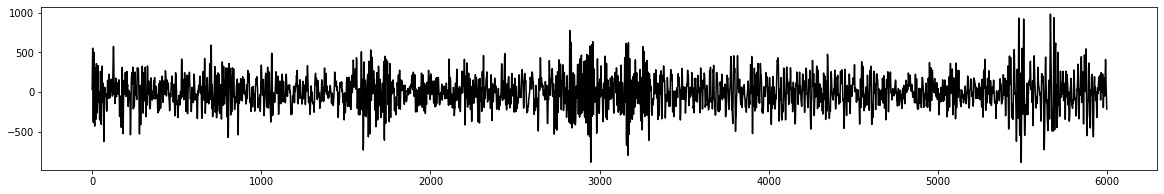

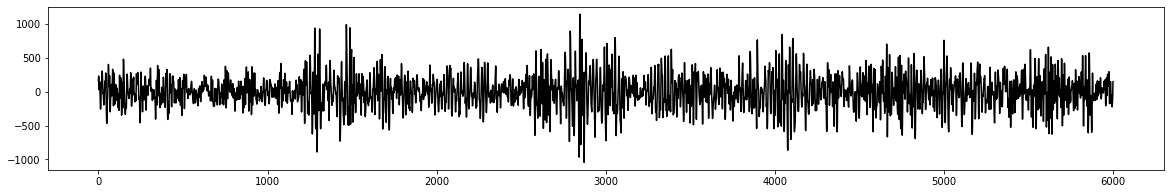

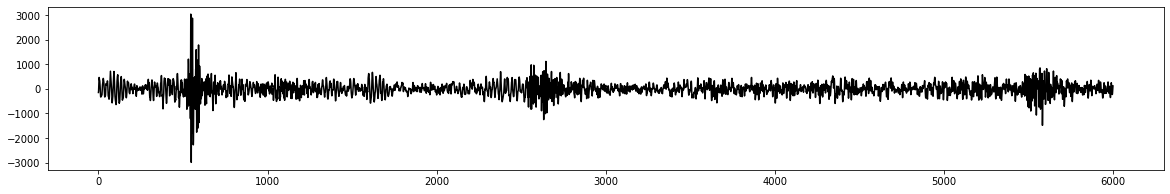

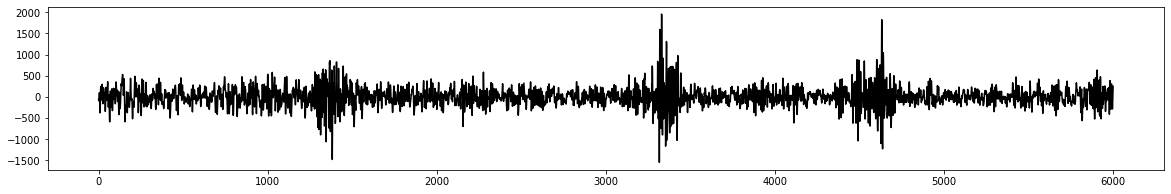

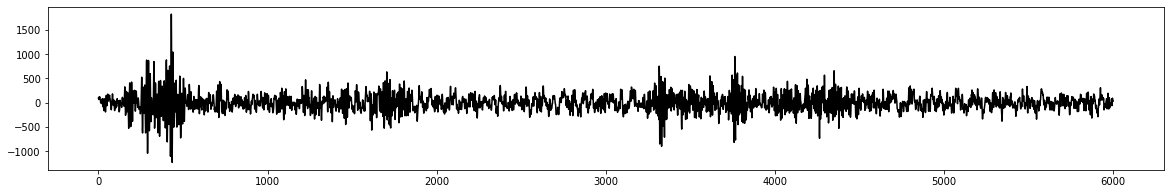

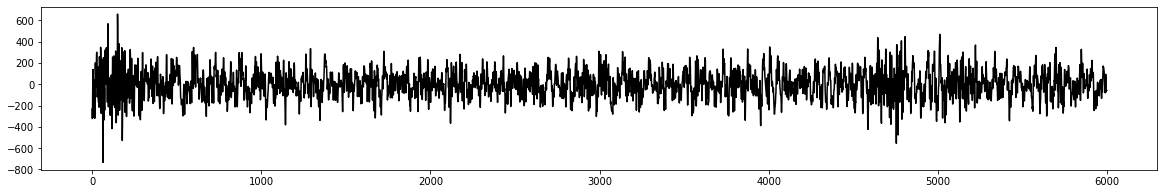

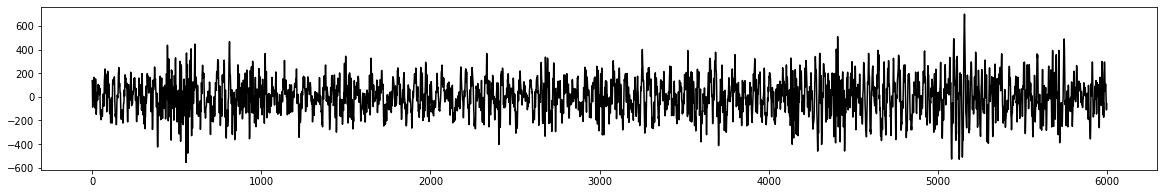

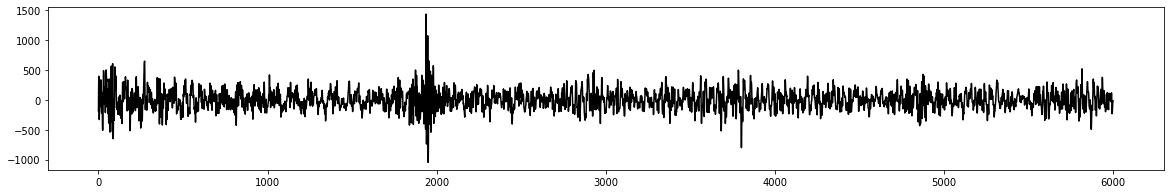

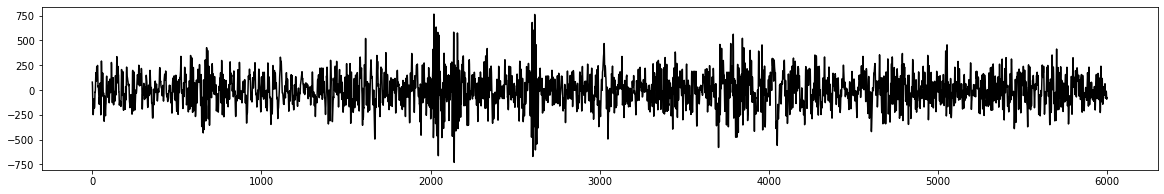

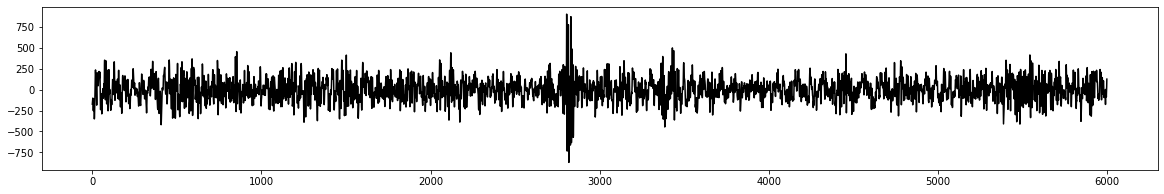

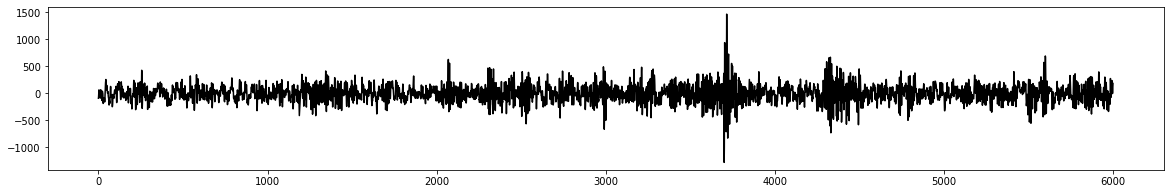

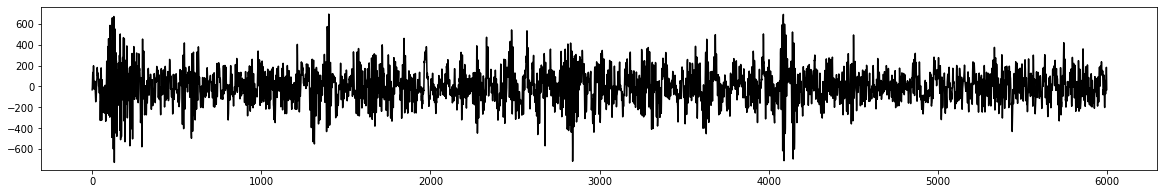

In [8]:
# for i in range(100):
#     plt.figure(figsize=(20,3))
#     plt.plot(data[f_data][i]['data'].T[0], color='black')
#     plt.show()